## ORF6-CTR NMR ANALYSIS 

## Introduction 

This jupyter notebook contains sample code to produce the NMR figures in the manuscript. 

Note that spectra figures are not included. All spectra shown in the manuscript were produced using NMRFAM-Sparky (1) and Adobe Illustrator. 

Amino acid sequence: `Ac-SKSLTENKYSQLDEEQPMEID` and `SKSLTENKYSQLDEEQPMEID`. 

All ft2 and ft3 files used for the assignment and analysis of ORF6-CTR and NAc-ORF6-CTR can be downloaded from Zenodo for you to repeat the analysis yourself. 

<b> References <b> 
    
1. Lee W, Tonelli M, Markley JL. 2015. NMRFAM-SPARKY: enhanced software for biomolecular NMR spectroscopy. Bioinformatics. 31:1325. 
 

## Setup the notebook 

In [1]:
#Import useful tools

import warnings
import os
import sys
from glob import glob
from itertools import *
from math import pi

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd

from sklearn.metrics import r2_score
from scipy.stats import linregress, ttest_ind, ttest_1samp, t
from scipy.optimize import curve_fit
from scipy import stats
import lmfit
from lmfit.models import LinearModel
from lmfit import Model, Parameters

In [2]:
# Turn off future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#Define presets for plotting
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=8)

# define colours for proline cis and trans 
orf6_ctr_cis = (1, 0, 1) # ff00ff
orf6_ctr_trans = (0.22,0.49,0.16) #rgb(55,126,34) green

# Define the width of the bars
width = 0.35

# Define the plus-minus symbol (±)
plus_minus = "\u00B1"

In [4]:
## Define temperature arrays in Kelvin

T = np.array([275.65,278.15,283.15,288.15,293.15,298.15,303.15,308.15,310.15,313.15])
T_recp = [1000 / t for t in T]

In [5]:
## Define residue arrays for plotting 

# All residues in ORF6-CTR
resid = np.arange(41, 62)
res_names = ['S41', 'K42', 'S43', 'L44', 'T45', 'E46', 'N47', 'K48', 'Y49', 'S50', 'Q51', 'L52', 'D53', 'E54','E55', 'Q56', 'P57', 'M58', 'E59', 'I60', 'D61']
# Create an index for the x-axis
res_names_index = np.arange(len(res_names))

# Define cis residues for populations 
isomers_residues = ['E55', 'Q56', 'P57', 'M58', 'E59']
# Create an index for the isomers residues 
isomers_residues_index = np.arange(len(isomers_residues))

# Set xticks for relaxation plots 
relaxation_ticks = [45, 50, 55, 60]

In [6]:
# Define constant's and other important numbers 
R = 8.314  # Ideal gas constant in J/(mol·K)

N_carrier_600 = 121.678 # 15N carrier (600 MHz) 
N_carrier_800 = 121.675 # 15N carrier (800 MHz) 
H_carrier_600 = 4.868 # proton carrier 
N_freq_600 = 60.797 # spectrometer frequency for 15N at 600 MHz 
N_freq_800 = 81.122 # spectrometer frequency for 15N at 800 MHz
H_freq_600 = 599.923 # spectrometer frequency for proton 
pwH_sl_600 = 25*1e-6  # pl25 on spectrometer in usec - convert to s 
pwN_sl_600 = 125*1e-6  # pl25 on spectrometer in usec - convert to s
spin_lock_field = 2000 # Spin lock field / Offset in Hz 
gamma_H1 = 267.5e6  # proton gyromagnetic ratio 
gamma_N15 = -27.1e6  # nitrogen gyromagentic ratio 
delta_csa = -172.0e-6 # 15N CSA tensor 
r_is = 1.02e-10 # Vibrationally averaged distance between proton and nitrogen in angstroms 
h = 6.626075e-34 # planck's constant

In [7]:
# Define NMR parameters 
B = H_freq_600 * 1e6 * 2.0 * np.pi / gamma_H1 # magentic field strength 
wh = B * gamma_H1 # omega H
wn = B * gamma_N15 # omega N 
c = B * gamma_N15 * delta_csa / np.sqrt(3.0) #  CSA 
d = (1e-7) * h * gamma_H1 * gamma_N15 * (r_is**-3.0) / (np.pi * 2.0) # dipolar coupling constant 

In [8]:
# Define model functions to be used in this notebook 

# Linear model 
def linear_model_function(x, slope, intercept):
    return slope * x + intercept
    
linear_model = Model(linear_model_function)

# Exponential decay function for exchange-free 15N transverse relaxation (this gives 2R_sigma_rho)
def exponential_decay_function(x, A, rate):
    return A * np.exp(-rate * x)

exponential_decay_model = Model(exponential_decay_function)

# Define the 2nd order Legendre polynomial 
def P2(z):
    return (3.*z*z-1.)/2.

# Define the calculation for theta N 
def CalcThetaN(offsetN_600):
    #offset must be in ppm
    kiN_600=(1./(4.*pwN_sl_600))/(N_freq_600*(offsetN_600-N_carrier_600))
    # return sin(atan(ki))^2.
    return kiN_600*kiN_600/(1.+kiN_600*kiN_600)

# Define the calculation for theta H
def CalcThetaH(offsetH):
    #offset must be in ppm
    kiH_600=(1./(4.*pwH_sl_600))/(H_freq_600*(offsetH-H_carrier_600))
    # return sin(atan(ki))^2.
    return kiH_600*kiH_600/(1.+kiH_600*kiH_600)

# Define the calculation for theta HN 
def CalcThetaHN(offsetHN):
    #offset must be in ppm
    kiHN_600=(1./(4.*pwHN_sl_600))/(HN_freq_600*(offsetHN_600-HN_carrier_600))
    # return sin(atan(ki))^2.
    return kiHN_600*kiHN_600/(1.+kiHN_600*kiHN_600)

# Define exponential function to fit inversion recovery intensities 
# Stejskal–Tanner equation to obtain 𝐷𝑡 
def dosy(x, Diff=1e-9): # Diff=1e-09 is in m2/s, x=gradient values should be in Tm-1
    gamma = 267.522 * 1000000  # 1H gyromag ratio s-1T-1
    tau = 0.0002 # time to phase/rephase bipolar gradients s
    big_del = 0.2  # diffusion time in s
    little_del = 0.0015*2  # gradient pulse lengths (so we need to double it) 
    return np.exp(-Diff*gamma**2*x**2*little_del**2*(big_del-little_del/3-tau/2))

def fit_DOSY_data(grads, ydata):
    mod = Model(dosy, independent_vars=['x'])
    # Initialise parameters
    mod.set_param_hint('Diff', value=1e-9)
    # Perform the fit
    out = mod.fit(ydata, x=grads)
    fit = out.best_fit
    #print(out.fit_report())
    D = out.params['Diff'].value
    D_err = out.params['Diff'].stderr
    return fit, D, D_err

## NAc-ORF6-CTR temperature coefficients 

The following code calculates the temperature coefficients for the N-acetylated ORF6-CTR with the P57 residue in the trans configuration. 1HN chemical shifts are from 1H-1H TOCSY spectra at 8 temperatures: 278 K, 283 K, 288 K, 293 K, 298 K, 303 K, 308 K, 310 K. 

In [9]:
## Prepare the chemical shifts for analysis 

# Read data into a list of DataFrames for the 8 temperatures
NAc_temp_titration = ['NAc-orf6-ctr/NAc_CTR-278.shifts', 'NAc-orf6-ctr/NAc_CTR-283.shifts', 'NAc-orf6-ctr/NAc_CTR-288.shifts', 'NAc-orf6-ctr/NAc_CTR-293.shifts','NAc-orf6-ctr/NAc_CTR-298.shifts','NAc-orf6-ctr/NAc_CTR-303.shifts','NAc-orf6-ctr/NAc_CTR-308.shifts','NAc-orf6-ctr/NAc_CTR-310.shifts']  # Add the filenames for the other temperatures here
NAc_temp_titration_df = [pd.read_csv(file, sep='\s+') for file in NAc_temp_titration]

# Combine all the DataFrames into a single DataFrame with a new column 'Temperature' to store the temperature index
combined_NAc_temp_titration = pd.concat([df.assign(Temperature=i+1) for i, df in enumerate(NAc_temp_titration_df)])

# Filter out rows with missing data for 'HN'
combined_NAc_temp_titration = combined_NAc_temp_titration[combined_NAc_temp_titration['HN'] != '-']

# Only want the HN shifts 
HN_NAc_orf6_ctr = combined_NAc_temp_titration['HN']

# now goes from residue 43-61 in blocks of increasing temperature  
HN_NAc_orf6_ctr_array = np.asarray(HN_NAc_orf6_ctr)

# Convert empty strings to nan
HN_NAc_orf6_ctr_array[HN_NAc_orf6_ctr_array == ''] = np.nan

# Convert the array to float (ignores the nan values)
HN_NAc_orf6_ctr_ppm = HN_NAc_orf6_ctr_array.astype(float)

# convert from ppm to ppb 
HN_NAc_orf6_ctr_ppb = HN_NAc_orf6_ctr_ppm * 1000

# reshape the array per residue for the chemical shifts at 8 different temperatures 
HN_NAc_orf6_ctr_residues = np.reshape(HN_NAc_orf6_ctr_ppb, (18,8),order='F')

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_97548/4124514577.py:5: SyntaxWarning: invalid escape sequence '\s'
  NAc_temp_titration_df = [pd.read_csv(file, sep='\s+') for file in NAc_temp_titration]


Results for residue number 43:
[[Model]]
    Model(linear_model_function)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 8
    # variables        = 2
    chi-square         = 41.9622196
    reduced chi-square = 6.99370327
    Akaike info crit   = 17.2586251
    Bayesian info crit = 17.4175082
    R-squared          = 0.99932742
[[Variables]]
    slope:     -8.08894136 +/- 0.08567135 (1.06%) (init = -8)
    intercept:  10712.2122 +/- 25.3138826 (0.24%) (init = 10000)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9993
Results for residue number 44:
[[Model]]
    Model(linear_model_function)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 8
    # variables        = 2
    chi-square         = 72.5855962
    reduced chi-square = 12.0975994
    Akaike info crit   = 21.6425997
    Bayesian info crit = 21.8014828
    R-squared          = 0.99896

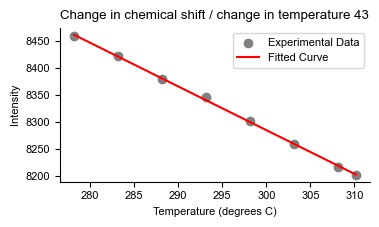

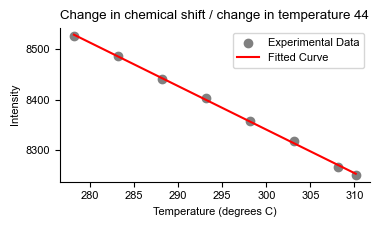

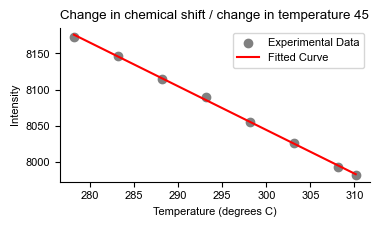

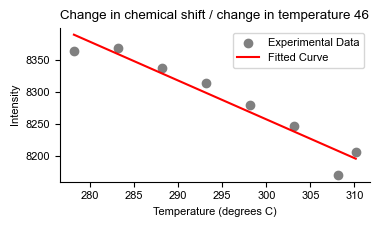

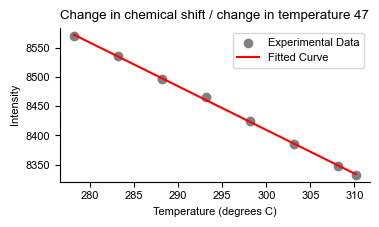

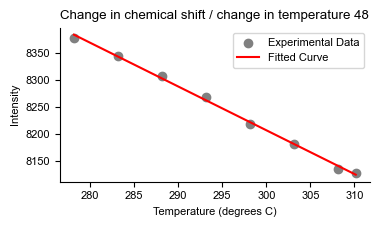

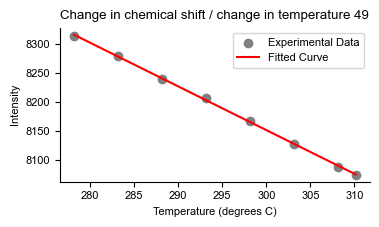

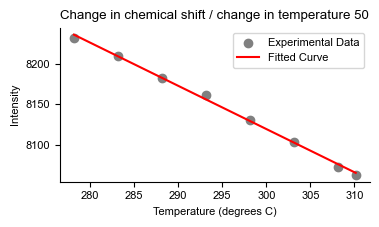

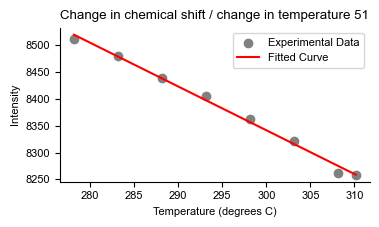

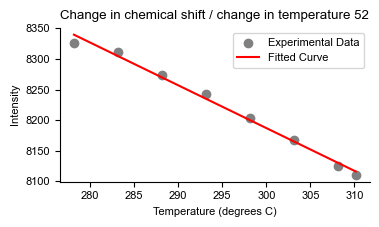

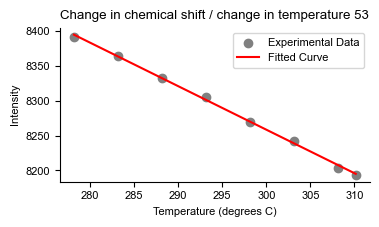

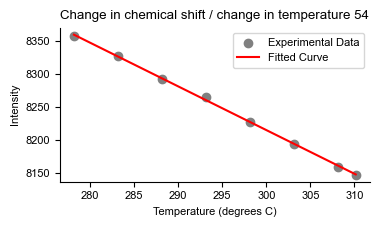

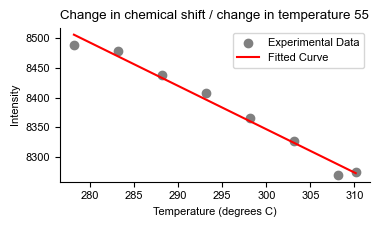

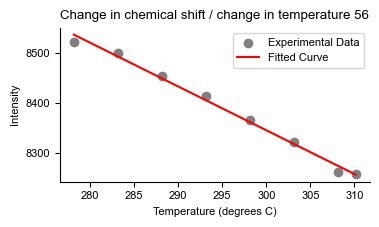

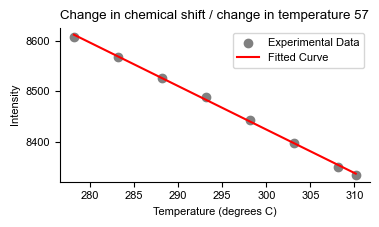

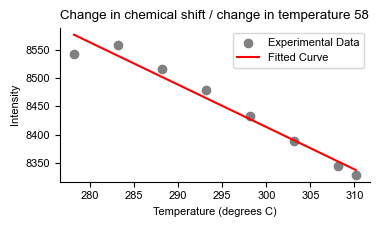

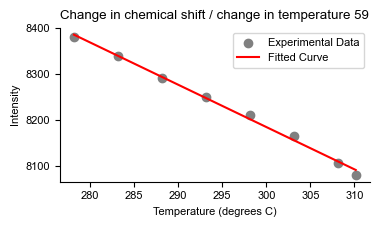

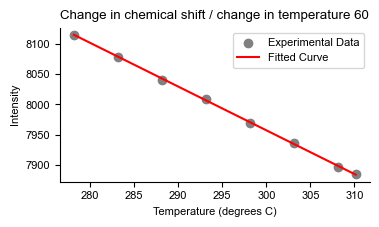

In [10]:
## Fit change in NAc-ORF6-CTR (ppb) chemical shift to change in temperature 

# Define empty arrays to store slope and standard error of the slope
temp_coefficients = np.zeros(len(HN_NAc_orf6_ctr_residues)) # this is the gradient (temp coefficient)
stderr_temp_coefficients = np.zeros(len(HN_NAc_orf6_ctr_residues)) # (this is the standard error in the temp coefficient) 

# Loop over each residue in HN_NAc_orf6_ctr_residues
for i in range((len(HN_NAc_orf6_ctr_residues))):

    # Provide initial parameter guesses
    temp_coefficient_params = linear_model.make_params(slope=-8, intercept=10000) 
    
    # Fit the model to NAc-ORF6-CTR temperature titration data 
    temp_coefficient_result = linear_model.fit(HN_NAc_orf6_ctr_residues[i], temp_coefficient_params, x=T[1:-1])

    # Store the temp coefficients and standard error in the arrays defined above 
    temp_coefficients[i] = temp_coefficient_result.params['slope'].value
    stderr_temp_coefficients[i] = temp_coefficient_result.params['slope'].stderr

    # Print the fit results
    print(f"Results for residue number {i+43}:")
    print(temp_coefficient_result.fit_report())

    # Plot the results for each residue 
    plt.figure(figsize=(4, 2))
    plt.scatter(T[1:-1], HN_NAc_orf6_ctr_residues[i], color='grey', label='Experimental Data')
    plt.plot(T[1:-1], temp_coefficient_result.best_fit, color='r', label='Fitted Curve')

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.xlabel('Temperature (degrees C)')
    plt.ylabel('Intensity')
    plt.title(f'Change in chemical shift / change in temperature {i+43}')
    plt.legend()

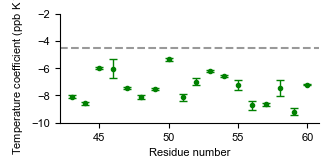

In [11]:
## Make figure 

fig, (ax1) = plt.subplots(1, 1)

# Plot scatter points with error bars 
ax1.errorbar(resid[2:-1], temp_coefficients, yerr=stderr_temp_coefficients, color='green',
             marker='o', markersize=3, capsize=3,label=r'$\mathit{cis}$',linewidth=1,linestyle='None')

ax1.set_ylabel('Temperature coefficient (ppb K$^-$$^1$)')
ax1.set_xlabel('Residue number')
ax1.set_ylim(-10,-2)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.axhline(y = -4.5, color='black', alpha=0.4,linestyle='--')

# Set the figure size in mm
plt.gcf().set_size_inches(85/ 25.4,36/25.4)

# Show the plot
#plt.savefig('figures/temp_coefficient.pdf', format='pdf', dpi=2000,transparent=True,bbox_inches='tight')

## ORF6-CTR secondary structure propensity at 288 K

To assess residual secondary structure of the ORF6-CTR we used the secondary structure propensity score algorithm (2). We input the 1Halpha, 13Calpha and 13Cbeta chemical shifts at 288.15 K for the cis-P57 and trans-P57 configurations. 

The code to do this yourself can be downloaded from: http://pound.med.utoronto.ca/software.html

<b> References <b> 

2. Marsh JA, Singh VK, Jia Z, Forman-Kay JD. 2006. Sensitivity of secondary structure propensities to sequence differences between α- and γ-synuclein: Implications for fibrillation. Protein Sci. 15:2795. 

In [12]:
## upload SSP data for trans 

# Read the CSV file, skipping the first column
trans_ssp_288K_input = pd.read_csv('orf6-ctr/ssp_orf6_ctr_trans_15deg/ssp-orf6-ctr-288K-trans.txt', delim_whitespace=True, dtype={'column_name_with_strings': str}, header=0)
cis_ssp_288K_input = pd.read_csv('orf6-ctr/ssp_orf6_ctr_cis_15deg/ssp-orf6-ctr-288K-cis.txt', delim_whitespace=True, dtype={'column_name_with_strings': str}, header=0)

### TRANS-P57
#output 2-19 - does not give result for S43 

# convert to numpy array 
trans_ssp_288K_array = trans_ssp_288K_input.to_numpy()

# transpose 
trans_ssp_288K_all = np.transpose(trans_ssp_288K_array)

# just save the ssp results to an array 
trans_ssp_288K = trans_ssp_288K_all[1]

# did not work for res 1 or res 14 - need to insert them in (in python speak, 0 and 13), also want to add 41 and 42 
# Ignores residues immediately preceding prolines which are often extreme outliers. Set to 1 by default. (so no result for Q56) 
positions_ssp = [0,0,0,12] # add extra data (don't have 41,42,43 or 56) 
trans_ssp_288K_all_res = np.insert(trans_ssp_288K, positions_ssp, 0)
trans_ssp_288K_masked = ma.masked_equal(trans_ssp_288K_all_res, 0)

### CIS-P57 

# convert to numpy array 
cis_ssp_288K_array = cis_ssp_288K_input.to_numpy()

# transpose 
cis_ssp_288K_all = np.transpose(cis_ssp_288K_array)

# just save the ssp results to an array 
cis_ssp_288K = cis_ssp_288K_all[1] 
cis_ssp_288K_all_res = np.insert(cis_ssp_288K, positions_ssp, 0)

# cis res - only confirm assignment for 55,56,57,58,59 (only want to plot these residues) 
cis_ssp_288K_all_res[:-7] = 0 
cis_ssp_288K_all_res[-2:] = 0
cis_ssp_288K_masked = ma.masked_equal(cis_ssp_288K_all_res, 0)

Text(0.5, 1.0, 'Using CA, CB, HA for ORF6-CTR at 288 K')

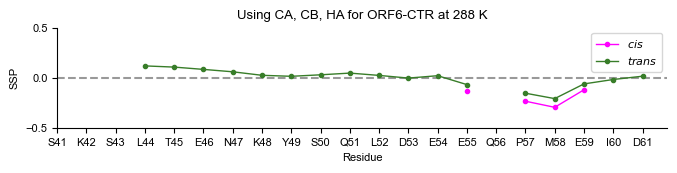

In [13]:
# plot SSP as a function of residue number 

# alpha helix residues = positive
# beta-strand residues = negative 
fig, ax = plt.subplots(figsize=(6,2))  # Adjust the width (8) and height (4) as needed

# Plot the data 
ax.plot(res_names_index, cis_ssp_288K_masked, marker='o', color=orf6_ctr_cis, label=r'$\mathit{cis}$', linewidth=1, markersize=3)
ax.plot(res_names_index, trans_ssp_288K_masked, marker='o', color=orf6_ctr_trans, label=r'$\mathit{trans}$', linewidth=1, markersize=3)

# Customize the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Residue')
ax.set_ylabel('SSP')
ax.axhline(y=0, color='black', linestyle='--',alpha=0.4,zorder=-1)
ax.set_ylim(-0.5, 0.5)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))

# Set the x-axis labels
ax.set_xticks(res_names_index)
ax.set_xticklabels(res_names)

# Set the figure size in mm
plt.gcf().set_size_inches(200/ 25.4, 33/ 25.4)

ax.legend()
ax.set_title('Using CA, CB, HA for ORF6-CTR at 288 K')
#plt.savefig('figures/ssp.pdf', format='pdf', dpi=2000,transparent=True,bbox_inches='tight')

## P57 populations and Van't Hoff plots 

To calculate cis-P57 populations and produce the Van't Hoff plots we recorded a temperature titration of 1H-15N HSQC's at 10 different temperatures: 275.65 K,278 K, 283 K, 288 K, 293 K, 298 K, 303 K, 308 K, 310 K, and 313 K. 

Using NMRFAM-Sparky (1) we calculated the peak height and the integrated peak volume. 

In [14]:
# read in the 1H-15N HSQC chemical shifts, peak heights and peak integrated volumes
orf6_ctr_hsqc = ['orf6-ctr/1H-15N-temp-titration/1H-15N-HSQC-275.65.list', 'orf6-ctr/1H-15N-temp-titration/1H-15N-HSQC-278.list', 'orf6-ctr/1H-15N-temp-titration/1H-15N-HSQC-283.list', 'orf6-ctr/1H-15N-temp-titration/1H-15N-HSQC-288.list','orf6-ctr/1H-15N-temp-titration/1H-15N-HSQC-293.list','orf6-ctr/1H-15N-temp-titration/1H-15N-HSQC-298.list','orf6-ctr/1H-15N-temp-titration/1H-15N-HSQC-303.list','orf6-ctr/1H-15N-temp-titration/1H-15N-HSQC-308.list','orf6-ctr/1H-15N-temp-titration/1H-15N-HSQC-310.list','orf6-ctr/1H-15N-temp-titration/1H-15N-HSQC-313.list'] 
orf6_ctr_hsqc_data = [pd.read_csv(file, sep='\s+') for file in orf6_ctr_hsqc]

# Combine all the DataFrames into a single DataFrame with a new column 'Temperature' to store the temperature index
orf6_ctr_hsqc_data_temp = pd.concat([df.assign(Temperature=i+1) for i, df in enumerate(orf6_ctr_hsqc_data)])

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_97548/3242628958.py:3: SyntaxWarning: invalid escape sequence '\s'
  orf6_ctr_hsqc_data = [pd.read_csv(file, sep='\s+') for file in orf6_ctr_hsqc]


In [15]:
## Make two arrays for peak height cis and trans data 

#  From Sparky file 
peak_indices = [12, 14, 16, 18]  

# Make empty arrays 
trans_peak_height = np.zeros((4, 10))
cis_peak_height = np.zeros((4, 10))

# Fill the arrays with the peak data
for k, i in enumerate(peak_indices):
    trans_peak_height[k, :] = np.asarray(orf6_ctr_hsqc_data_temp['Data'][i]) # 'Data is header for peak height in Sparky file
    cis_peak_height[k, :] = np.asarray(orf6_ctr_hsqc_data_temp['Data'][i + 1])

# M58 cis is missing from 25 degrees C onwards - also change trans to 0 
cis_missing_peaks_index = (cis_peak_height[2] == 0)
trans_peak_height[2][cis_missing_peaks_index] = 0

In [16]:
## Make two arrays for integrated peak volume cis and trans data 

#  From Sparky file 
peak_indices = [12, 14, 16, 18]  

# Make empty arrays 
trans_peak_volume = np.zeros((4, 10))
cis_peak_volume = np.zeros((4, 10))

# Fill the arrays with the peak data
for k, i in enumerate(peak_indices):
    trans_peak_volume[k, :] = np.asarray(orf6_ctr_hsqc_data_temp['Volume'][i]) # 'Data is header for peak volume in Sparky file
    cis_peak_volume[k, :] = np.asarray(orf6_ctr_hsqc_data_temp['Volume'][i + 1])

# M58 cis is missing from 25 degrees C onwards - also change trans to 0 
cis_missing_peaks_index = (cis_peak_volume[2] == 0)
trans_peak_volume[2][cis_missing_peaks_index] = 0

In [17]:
# Calculate populations for all residues at all temperatures 

peak_height_pops = np.zeros((4,10))
peak_volume_pops = np.zeros((4,10))

for i in range(0,4):
    for k in range(0,10):
        # integrated peak height 
        if trans_peak_height[i][k] + cis_peak_height[i][k] != 0:
            peak_height_pops[i,k] = cis_peak_height[i][k] / (trans_peak_height[i][k] + cis_peak_height[i][k]) * 100
        else:
            # Set the result to zero (dealing with M58 data where it's 0) 
            peak_height_pops[i,k] = 0  
        
        # integrated peak volume
        if trans_peak_volume[i][k] + cis_peak_volume[i][k] != 0:
            peak_volume_pops[i,k] = cis_peak_volume[i][k] / (trans_peak_volume[i][k] + cis_peak_volume[i][k]) * 100
        else:
            # Set the result to zero (dealing with M58 data where it's 0) 
            peak_volume_pops[i,k] = 0  

# Calculate the mean and standard deviation for peak height and volume at 15 degC and 37 degC

# Remove M58 at 37 deg
peak_height_calc = peak_height_pops[:,-2][peak_height_pops[:,-2] != 0]
peak_volume_calc = peak_volume_pops[:,-2][peak_volume_pops[:,-2] != 0]

mean_peak_height_15 = np.mean(peak_height_pops[:,3])
mean_peak_height_37 = np.mean(peak_height_calc)
mean_peak_volume_15 = np.mean(peak_volume_pops[:,3])
mean_peak_volume_37 = np.mean(peak_volume_calc)

std_peak_height_15 = np.std(peak_height_pops[:,3])
std_peak_height_37 = np.std(peak_height_calc)
std_peak_volume_15 = np.std(peak_volume_pops[:,3])
std_peak_volume_37 = np.std(peak_volume_calc)

In [18]:
# Insert zero for P57 
peak_volume_pops_15 = np.insert(peak_volume_pops[:,3], 2, 0)
peak_volume_pops_37 = np.insert(peak_volume_pops[:,-2], 2, 0)
peak_height_pops_15 = np.insert(peak_height_pops[:,3], 2, 0)
peak_height_pops_37 = np.insert(peak_height_pops[:,-2], 2, 0)

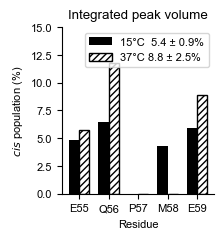

In [19]:
# Plot integrated peak volume 

fig, ax = plt.subplots(figsize=(50/ 25.4, 55/ 25.4))  # 1 inch = 25.4 mm

# 15 deg C
label_cis_vol = f'15°C  {mean_peak_volume_15:.1f} {plus_minus} {std_peak_volume_15:.1f}%'
ax.bar(isomers_residues_index - width/2, peak_volume_pops_15, width, label=label_cis_vol, color='black',linewidth=1)

# 37 deg C 
label_cis_vol = f'37°C {mean_peak_volume_37:.1f} {plus_minus} {std_peak_volume_37:.1f}%'
ax.bar(isomers_residues_index + width/2, peak_volume_pops_37, width, label=label_cis_vol, color='none', edgecolor='black',hatch='/////', linewidth=1)

# Set the x-axis labels
ax.set_xticks(isomers_residues_index)
ax.set_xticklabels(isomers_residues)

ax.set_ylim(0,15)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Integrated peak volume')

# Add labels and legend
ax.set_xlabel('Residue')
ax.set_ylabel(r'$\mathit{cis}$ population (%)')
ax.legend()

#plt.savefig('figures/pops_volume.pdf', format='pdf', dpi=2000,transparent=True,bbox_inches='tight')

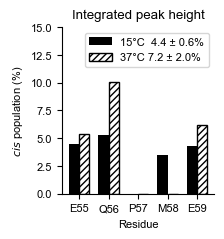

In [20]:
# Plot integrated peak height 

fig, ax = plt.subplots(figsize=(50/ 25.4, 55/ 25.4))  # 1 inch = 25.4 mm

# 15 deg C
label_cis_vol = f'15°C  {mean_peak_height_15:.1f} {plus_minus} {std_peak_height_15:.1f}%'
ax.bar(isomers_residues_index - width/2, peak_height_pops_15, width, label=label_cis_vol, color='black',linewidth=1)

# 37 deg C 
label_cis_vol = f'37°C {mean_peak_height_37:.1f} {plus_minus} {std_peak_height_37:.1f}%'
ax.bar(isomers_residues_index + width/2, peak_height_pops_37, width, label=label_cis_vol, color='none', edgecolor='black',hatch='/////', linewidth=1)

# Set the x-axis labels
ax.set_xticks(isomers_residues_index)
ax.set_xticklabels(isomers_residues)

ax.set_ylim(0,15)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Integrated peak height')

# Add labels and legend
ax.set_xlabel('Residue')
ax.set_ylabel(r'$\mathit{cis}$ population (%)')
ax.legend()

#plt.savefig('figures/pops_peak_height.pdf', format='pdf', dpi=2000,transparent=True,bbox_inches='tight')

In [21]:
# Van't Hoff analysis for proline trans --> cis isomerisation, where K = [cis]/[trans]

# Calculate K = [cis]/[trans]
peak_height_ratio = np.zeros((4, 10))
peak_volume_ratio = np.zeros((4, 10))

for i in range(4):  # Loop over first three rows
    for k in range(10):
        # Exclude M58 from the calculation (merges at higher temps so cannot use) 
        if i != 2:
            peak_height_ratio[i, k] = cis_peak_height[i][k] / trans_peak_height[i][k]
            peak_volume_ratio[i, k] = cis_peak_volume[i][k] / trans_peak_volume[i][k]

# Take the natural logarithm of the ratio (NO M58) 
peak_height_log = np.log(peak_height_ratio[[0, 1, 3], :])
peak_volume_log = np.log(peak_volume_ratio[[0, 1, 3], :])

# Calculate the mean and standard deviation for E55, Q56, and E59 - using all 3 residues in Van't Hoff plot
mean_peak_height_log = np.mean(peak_height_log,axis=0)
std_peak_height_log = np.std(peak_height_log,axis=0)
mean_volume_log = np.mean(peak_volume_log,axis=0)
std_volume_log = np.std(peak_volume_log,axis=0)

In [22]:
# Fit the linear model to ln(K) vs 1/T to plot Van't Hoff analysis for pro trans --> cis isomerisation

# Provide initial parameter guesses
vh_params = linear_model.make_params(slope=-2.0, intercept=1.0)

# Fit the linear model to peak height (use weights to take into account standard deviation of each point) 
vh_peak_height_result = linear_model.fit(mean_peak_height_log, vh_params, x=T_recp, weights=1/std_peak_height_log)
vh_volume_result = linear_model.fit(mean_volume_log, vh_params, x=T_recp, weights=1/std_volume_log)

# Print the Van't Hoff linear model fit results
print(vh_peak_height_result.fit_report())
print(vh_volume_result.fit_report())


[[Model]]
    Model(linear_model_function)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 10
    # variables        = 2
    chi-square         = 0.44374226
    reduced chi-square = 0.05546778
    Akaike info crit   = -27.1509648
    Bayesian info crit = -26.5457946
    R-squared          = 0.56481803
[[Variables]]
    slope:     -1.73558367 +/- 0.10559092 (6.08%) (init = -2)
    intercept:  3.01730922 +/- 0.36976729 (12.25%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9998
[[Model]]
    Model(linear_model_function)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 10
    # variables        = 2
    chi-square         = 2.04580306
    reduced chi-square = 0.25572538
    Akaike info crit   = -11.8679469
    Bayesian info crit = -11.2627767
    R-squared          = 0.18849406
[[Variables]]
    slope:     -1.96914783 +/- 0.23545073

In [23]:
# select temperature in Kelvin for analysis (change accordingly) 
sele_T = 310.15 

ΔH: 16.4 ± 2.0 kJ/mol and ΔS: 33.9 ± 6.6 J/mol/K
ΔG: 5.9 ± 2.8 kJ/mol


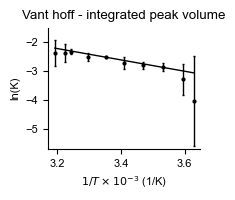

In [24]:
# Van't hoff plot for peak height

plt.errorbar(T_recp, mean_volume_log, yerr=std_volume_log, marker='o',markersize=2,linestyle='None', color='black', capsize=1, linewidth=1,label='Error Bars')

# Plot the line of best fit for the integrated peak volume (calculate dS and dH)
plt.plot(T_recp, vh_volume_result.best_fit, color='black',linewidth=1)

# Add labels and legend
plt.xlabel(r'$1/T \times 10^{-3}$ (1/K)')
plt.ylabel('ln(K)')
plt.title("Vant hoff - integrated peak volume")

plt.ylim(-5.7,-1.5)

# Remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set the figure size in mm
plt.gcf().set_size_inches(50/ 25.4, 40/ 25.4)

#plt.savefig('figures/vanthoff_volume.pdf', format='pdf', dpi=2000,transparent=True,bbox_inches='tight')

# Show deltaS and deltaH
delta_H_volume = vh_volume_result.params['slope'].value * -R
delta_H_volume_err = np.abs(vh_volume_result.params['slope'].stderr * -R)
delta_S_volume = vh_volume_result.params['intercept'].value * (R)
delta_S_volume_err = vh_volume_result.params['intercept'].stderr * R
delta_G_volume = delta_H_volume - (sele_T * delta_S_volume/1000)
delta_G_volume_err = np.sqrt(delta_H_volume_err**2+(sele_T*(delta_S_volume_err/1000))**2)

print(f"ΔH: {delta_H_volume:.1f} {plus_minus} {delta_H_volume_err:.1f} kJ/mol and ΔS: {delta_S_volume:.1f} {plus_minus} {delta_S_volume_err:.1f} J/mol/K")
print(f"ΔG: {delta_G_volume:.1f} {plus_minus} {delta_G_volume_err:.1f} kJ/mol")

ΔH: 14.4 ± 0.9 kJ/mol and ΔS: 25.1 ± 3.1 J/mol/K
ΔG: 6.6 ± 1.3 kJ/mol


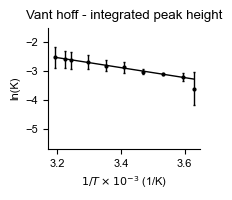

In [25]:
# Van't hoff plot for peak height

plt.errorbar(T_recp, mean_peak_height_log, yerr=std_peak_height_log, marker='o',markersize=2,linestyle='None', color='black', capsize=1, linewidth=1,label='Error Bars')

# Plot the line of best fit for the integrated peak volume (calculate dS and dH)
plt.plot(T_recp, vh_peak_height_result.best_fit, color='black',linewidth=1)

# Add labels and legend
plt.xlabel(r'$1/T \times 10^{-3}$ (1/K)')
plt.ylabel('ln(K)')
plt.title("Vant hoff - integrated peak height")

plt.ylim(-5.7,-1.5)

# Remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set the figure size in mm
plt.gcf().set_size_inches(50/ 25.4, 40/ 25.4)

#plt.savefig('figures/vanthoff_volume.pdf', format='pdf', dpi=2000,transparent=True,bbox_inches='tight')

# Show deltaS and deltaH
delta_H_peak_height = vh_peak_height_result.params['slope'].value * -R
delta_H_peak_height_err = np.abs(vh_peak_height_result.params['slope'].stderr * -R)
delta_S_peak_height = vh_peak_height_result.params['intercept'].value * (R)
delta_S_peak_height_err = vh_peak_height_result.params['intercept'].stderr * R
delta_G_peak_height = delta_H_peak_height - (sele_T * delta_S_peak_height/1000)
delta_G_peak_height_err = np.sqrt(delta_H_peak_height_err**2+(sele_T*(delta_S_peak_height_err/1000))**2)

print(f"ΔH: {delta_H_peak_height:.1f} {plus_minus} {delta_H_peak_height_err:.1f} kJ/mol and ΔS: {delta_S_peak_height:.1f} {plus_minus} {delta_S_peak_height_err:.1f} J/mol/K")
print(f"ΔG: {delta_G_peak_height:.1f} {plus_minus} {delta_G_peak_height_err:.1f} kJ/mol")

In [26]:
# Determine the cis-P57 populations from the Van't hoff analysis 

# save the slope and gradient from the above plots to an array 
vh_volume = np.array([vh_volume_result.params['slope'].value,vh_volume_result.params['intercept'].value])
vh_peak_height = np.array([vh_peak_height_result.params['slope'].value,vh_peak_height_result.params['intercept'].value])

# Save errors associated with slopes and intercepts to make life easier 
error_slope_vh_volume = vh_volume_result.params['slope'].stderr
error_intercept_vh_volume = vh_volume_result.params['intercept'].stderr
error_slope_vh_peak_height = vh_peak_height_result.params['slope'].stderr
error_intercept_vh_peak_height = vh_peak_height_result.params['intercept'].stderr

# Van't Hoff model (lnK = mx + c, using values of m and c) 
vh_volume_model = np.poly1d(vh_volume)
vh_peak_height_model = np.poly1d(vh_peak_height)

# 1/T * 10^-3 at selected temp
sele_T_recp = (1 / sele_T)*1000

# Get lnK from the Van't Hoff model by putting in specific x value (sele_T_recp)
lnK_volume = vh_volume_model(sele_T_recp)
lnK_peak_height = vh_peak_height_model(sele_T_recp)

# Calculate K (cis population) from lnK
vh_volume_cis = np.exp(lnK_volume)*100
vh_peak_height_cis = np.exp(lnK_peak_height)*100

# Error propagation - taking into account the standard error in the slope and standard error in the intercept 
error_vh_volume_cis = np.abs(vh_volume_cis) * np.sqrt((error_slope_vh_volume / vh_volume[0])**2 + (error_intercept_vh_volume / vh_volume[1])**2)
error_vh_peak_height_cis = np.abs(vh_peak_height_cis) * np.sqrt((error_slope_vh_peak_height / vh_peak_height[0])**2 + (error_intercept_vh_peak_height / vh_peak_height[1])**2)

# print the result
print('cis population using integrated volume at', sele_T,'K', 'is',  vh_volume_cis, '+/-', error_vh_volume_cis)
print('cis population using peak height at', sele_T,'K', 'is',  vh_peak_height_cis, '+/-', error_vh_peak_height_cis)

cis population using integrated volume at 310.15 K is 10.335014702684404 +/- 2.3527705000416095
cis population using peak height at 310.15 K is 7.587712310137315 +/- 1.038146214769644


## 15N relaxation data analysis 

Each subdirectory in the cis or trans directories contains a param.fuda file to quantify peak intensities and to fit the intensity profiles to mono-exponential decay functions (.out files) from each relaxation experiment using FuDA (3). 

To calculate NOEs, the NOE.py python script was used to calculate the ratio and uncertainty assuming that the first value is from the reference spectra and the second value is the NOE taken from the FuDA (.out) files. 

15N-exchange free experiments measured four 1H-15N relaxation rares with 8 delay times each. The run.sh script was used to separate the FuDA output files into tau, intensity, and esd in blocks of 8 (12 columns total) for processing (600_rdd/Four_rates/Four_rates_{resID}.out)

<b> References <b> 

3. Hansen DF, Yang D, Feng H, Zhou Z, Wiesner S, Bai Y, Kay LE. 2007. An exchange-free measure of 15N transverse relaxation: an NMR spectroscopy application to the study of a folding intermediate with pervasive chemical exchange. J Am Chem Soc. 129:11468–79. 

In [27]:
## Load trans-P57 relaxation data 

# 600 MHz 
r1_trans_600 = pd.read_csv('orf6-ctr/relaxation_data/trans/600_r1/r1_600.txt',delim_whitespace=True,dtype=float,header=None)
r1rho_trans_600 = pd.read_csv('orf6-ctr/relaxation_data/trans/600_r1rho/r1_rho_600.txt',delim_whitespace=True,dtype=float,header=None)
noe_trans_600 = pd.read_csv('orf6-ctr/relaxation_data/trans/600_noe/noe_600.fit',delim_whitespace=True,dtype=float,header=None)

# 800 MHz 
r1_trans_800 = pd.read_csv('orf6-ctr/relaxation_data/trans/800_r1/r1_800.txt',delim_whitespace=True,dtype=float,header=None)
r1rho_trans_800 = pd.read_csv('orf6-ctr/relaxation_data/trans/800_r1rho/r1_rho_800.txt',delim_whitespace=True,dtype=float,header=None)
noe_trans_800 = pd.read_csv('orf6-ctr/relaxation_data/trans/800_noe/noe_800.fit',delim_whitespace=True,dtype=float,header=None)

# Import chemical shift data 
cs_trans_600 = pd.read_csv('orf6-ctr/relaxation_data/trans/15N-HSQC-600.list',delim_whitespace=True,dtype=float,header=None)
cs_trans_800 = pd.read_csv('orf6-ctr/relaxation_data/trans/15N-HSQC-800.list',delim_whitespace=True,dtype=float,header=None)

In [28]:
## Load cis-P57 relaxation data 

# 600 MHz 
r1_cis_600 = pd.read_csv('orf6-ctr/relaxation_data/cis/600_r1/r1_600_cis.txt',delim_whitespace=True,dtype=float,header=None)
r1rho_cis_600 = pd.read_csv('orf6-ctr/relaxation_data/cis/600_r1rho/r1_rho_600_cis.txt',delim_whitespace=True,dtype=float,header=None)

# 800 MHz 
r1_cis_800 = pd.read_csv('orf6-ctr/relaxation_data/cis/800_r1/r1_800_cis.txt',delim_whitespace=True,dtype=float,header=None)
r1rho_cis_800 = pd.read_csv('orf6-ctr/relaxation_data/cis/800_r1rho/r1_rho_800_cis.txt',delim_whitespace=True,dtype=float,header=None)

# Import chemical shift data  
cs_cis_600 = pd.read_csv('orf6-ctr/relaxation_data/cis/15N-HSQC-600.list',delim_whitespace=True,dtype=float,header=None)
cs_cis_800 = pd.read_csv('orf6-ctr/relaxation_data/cis/15N-HSQC-800.list',delim_whitespace=True,dtype=float,header=None)

In [29]:
## Make relaxation and chemical shift data into numpy arrays

r1_trans_600 = r1_trans_600.to_numpy()
r1rho_trans_600 = r1rho_trans_600.to_numpy()
noe_trans_600 = noe_trans_600.to_numpy()
r1_trans_800 = r1_trans_800.to_numpy()
r1rho_trans_800 = r1rho_trans_800.to_numpy()
noe_trans_800 = noe_trans_800.to_numpy()
r1_cis_600 = r1_cis_600.to_numpy()
r1rho_cis_600 = r1rho_cis_600.to_numpy()
r1_cis_800 = r1_cis_800.to_numpy()
r1rho_cis_800 = r1rho_cis_800.to_numpy()

cs_trans_600 = cs_trans_600.to_numpy()
cs_trans_800 = cs_trans_800.to_numpy()

cs_cis_600 = cs_cis_600.to_numpy()
cs_cis_800 = cs_cis_800.to_numpy()

<b> Calculate R2 <b> 

In [30]:
# Calculate spin-lock / offset **2  for eq. S2 in manuscript 

#Calculate offset for each residue 
cs_offset_trans_ppm_600 = np.zeros(18)
for i in range(0,18):
    cs_offset_trans_ppm_600[i] = cs_trans_600[i,0]-N_carrier_600 

cs_offset_trans_ppm_800 = np.zeros(18)
for i in range(0,18):
    cs_offset_trans_ppm_800[i] = cs_trans_800[i,0]-N_carrier_800 

cs_offset_cis_ppm_600 = np.zeros(2)
for i in range(0,2):
    cs_offset_cis_ppm_600[i] = cs_cis_600[i,0]-N_carrier_600 

cs_offset_cis_ppm_800 = np.zeros(3)
for i in range(0,3):
    cs_offset_cis_ppm_800[i] = cs_cis_800[i,0]-N_carrier_800 
    
# Convert ppm to Hz 
cs_offset_trans_Hz_600 = np.zeros(18)
for i in range(0,18):
    cs_offset_trans_Hz_600[i] = cs_offset_trans_ppm_600[i]*N_freq_600 

cs_offset_trans_Hz_800 = np.zeros(18)
for i in range(0,18):
    cs_offset_trans_Hz_800[i] = cs_offset_trans_ppm_800[i]*N_freq_800 

cs_offset_cis_Hz_600 = np.zeros(2)
for i in range(0,2):
    cs_offset_cis_Hz_600[i] = cs_offset_cis_ppm_600[i]*N_freq_600 

cs_offset_cis_Hz_800 = np.zeros(3)
for i in range(0,3):
    cs_offset_cis_Hz_800[i] = cs_offset_cis_ppm_800[i]*N_freq_800 

# Spin lock field / Offset in Hz 
spinlock_offset_trans_600 = spin_lock_field/cs_offset_trans_Hz_600
spinlock_offset_trans_800 = spin_lock_field/cs_offset_trans_Hz_800
spinlock_offset_cis_600 = spin_lock_field/cs_offset_cis_Hz_600
spinlock_offset_cis_800 = spin_lock_field/cs_offset_cis_Hz_800

#Squared
sl_trans_600 = spinlock_offset_trans_600**2
sl_trans_800 = spinlock_offset_trans_800**2
sl_cis_600 = spinlock_offset_cis_600**2
sl_cis_800 = spinlock_offset_cis_800**2

In [31]:
# Calculate R2 and error propagation for TRANS 600 data 
r2_trans_600 = np.zeros(18)
r2_trans_600_error = np.zeros(18)

for i in range(0,18):
    r2_trans_600[i] = (r1rho_trans_600[i,1] * (sl_trans_600[i] + 1) - r1_trans_600[i,1]) / sl_trans_600[i]
    r2_trans_600_error[i] = np.sqrt((r1rho_trans_600[i,2] * (sl_trans_600[i] + 1)/sl_trans_600[i])**2 + ((r1_trans_600[i,1]/sl_trans_600[i])**2))     

In [32]:
# Calculate R2 and error propagation for TRANS 800 data 
r2_trans_800 = np.zeros(18)
r2_trans_800_error = np.zeros(18)

for i in range(0,18):
    r2_trans_800[i] = (r1rho_trans_800[i,1] * (sl_trans_800[i] + 1) - r1_trans_800[i,1]) / sl_trans_800[i]
    r2_trans_800_error[i] = np.sqrt((r1rho_trans_800[i,2] * (sl_trans_800[i] + 1)/sl_trans_800[i])**2 + ((r1_trans_800[i,1]/sl_trans_800[i])**2))     

In [33]:
# Calculate R2 and error propagation for CIS 600 data 
r2_cis_600 = np.zeros(2)
r2_cis_600_error = np.zeros(2)

for i in range(0,2):
    r2_cis_600[i] = (r1rho_cis_600[i,1] * (sl_cis_600[i] + 1) - r1_cis_600[i,1]) / sl_cis_600[i]
    r2_cis_600_error[i] = np.sqrt((r1rho_cis_600[i,2] * (sl_cis_600[i] + 1)/sl_cis_600[i])**2 + ((r1_cis_600[i,1]/sl_cis_600[i])**2))     

In [34]:
# Calculate R2 and error propagation for CIS 800 data 
r2_cis_800 = np.zeros(3)
r2_cis_800_error = np.zeros(3)

for i in range(0,3):
    r2_cis_800[i] = (r1rho_cis_800[i,1] * (sl_cis_800[i] + 1) - r1_cis_800[i,1]) / sl_cis_800[i]
    r2_cis_800_error[i] = np.sqrt((r1rho_cis_800[i,2] * (sl_cis_800[i] + 1)/sl_cis_800[i])**2 + ((r1_cis_800[i,1]/sl_cis_800[i])**2))     

In [35]:
## Calculate mean and standard deviation for each rate 
r1_cis_mean_600 = r1_cis_600[:,1].mean()
r1_cis_mean_800 = r1_cis_800[:,1].mean()

r1rho_cis_mean_600 = r1rho_cis_600[:,1].mean()
r1rho_cis_mean_800 = r1rho_cis_800[:,1].mean()

r2_cis_mean_600 = r2_cis_600.mean()
r2_cis_mean_800 = r2_cis_800.mean()

r1_trans_mean_600 = r1_trans_600[:,1].mean()
r1_trans_mean_800 = r1_trans_800[:,1].mean()

r1rho_trans_mean_600 = r1rho_trans_600[:,1].mean()
r1rho_trans_mean_800 = r1rho_trans_800[:,1].mean()

r2_trans_mean_600 = r2_trans_600.mean()
r2_trans_mean_800 = r2_trans_800.mean()

r1_cis_std_600 = r1_cis_600[:,1].std()
r1_cis_std_800 = r1_cis_800[:,1].std()

r1rho_cis_std_600 = r1rho_cis_600[:,1].std()
r1rho_cis_std_800 = r1rho_cis_800[:,1].std()

r2_cis_std_600 = r2_cis_600.std()
r2_cis_std_800 = r2_cis_800.std()

r1_trans_std_600 = r1_trans_600[:,1].std()
r1_trans_std_800 = r1_trans_800[:,1].std()

r1rho_trans_std_600 = r1rho_trans_600[:,1].std()
r1rho_trans_std_800 = r1rho_trans_800[:,1].std()

r2_trans_std_600 = r2_trans_600.std()
r2_trans_std_800 = r2_trans_800.std()

print('r1 cis 600', r1_cis_mean_600,r1_cis_std_600)
print('r1 cis 800', r1_cis_mean_800,r1_cis_std_800)
print('r1 trans 600', r1_trans_mean_600,r1_trans_std_600)
print('r1 trans 800', r1_trans_mean_800,r1_trans_std_800)

print('r2 cis 600', r2_cis_mean_600,r2_cis_std_600)
print('r2 cis 800', r2_cis_mean_800,r2_cis_std_800)
print('r2 trans 600', r2_trans_mean_600,r2_trans_std_600)
print('r2 trans 800', r2_trans_mean_800,r2_trans_std_800)

r1 cis 600 1.39146 0.16696
r1 cis 800 1.5462966666666667 0.05406000205532943
r1 trans 600 1.5111711111111115 0.17836696657574266
r1 trans 800 1.5072355555555557 0.15595219221936157
r2 cis 600 2.246427407875723 0.1150503869690298
r2 cis 800 2.567769619619795 0.2097467579777549
r2 trans 600 2.1842464980126817 0.3877025732022041
r2 trans 800 2.8066647068645665 0.4141113306173028


<b> Calculate trans-P57 Rdd (600 MHz) <b> 

In [36]:
## We are going to calculate Rdd from the 4 1H-15N relaxation rates measured in the NMR experiment 
# Note: there is a file called Rdd_600.txt where this has already been done

# This cell is just loading the 1H-15N relaxation data for the four rates 
Four_rates_dir = "orf6-ctr/relaxation_data/trans/600_rdd/Four_rates"  

# List of file numbers
file_numbers = list(range(43, 62))

# Empty dictionary to store the four rates input 
four_rates_input = {}

# Loop through each file number
for file_number in file_numbers:
    if file_number == 57:
        continue  # Skip file number 57 (proline so no data) 

    # Construct the full path to the file
    filename = os.path.join(Four_rates_dir, f'Four_rates_{file_number}.out')

    # Load the data from the file
    data = np.loadtxt(filename)

    # Store the data in a dictionary
    four_rates_input[file_number] = data

# Empty dictionary to store the data 
four_rates_t = {}

# Loop through each file number and transpose the data - then each residue has 12 columns with 8 values 
for file_number, data in four_rates_input.items():
    four_rates_t[file_number] = data.T

4 measured rate intensitites are combined as follows:

<b> I(2H‘zNz) × I(2HzN‘z)/[I(2H‘zN‘z) × I(2HzNz)] <b> 

In [37]:
# Combine the 4 measured rates 
combined_four_rates = np.zeros((19, 8), dtype=np.float64)

# Loop to iterate through each residue
for i in range(0,19):  
    residue_number = i + 43  # Convert to the actual residue number
    if residue_number in four_rates_t:  # Check if the data exists for this residue number
        for k in range(8): # Using the 8 relaxation delays 
            combined_four_rates[i][k] = (four_rates_t[residue_number][1][k] * four_rates_t[residue_number][4][k]) / (four_rates_t[residue_number][7][k] * four_rates_t[residue_number][10][k])

Rdd rates were quantified by fitting a single-exponential decay function of the form A * exp(-  R_{sigma,rho}*T_relax) to the time evolution of the 4 measured rates in the exchange free experiment. 

Residue 43: rate = 0.6441851995526092, stderr = 1.324420032887465
Residue 44: rate = 0.40516771977800653, stderr = 0.7730587331058728
Residue 45: rate = 1.22165550257399, stderr = 0.21365477185517298
Residue 46: rate = 0.9575573317948611, stderr = 0.26746571289124593
Residue 47: rate = 1.4259037222946314, stderr = 0.3545841090011149
Residue 48: rate = -0.031367632611830974, stderr = 0.24782817636810897
Residue 49: rate = 1.42565408987199, stderr = 0.29088079616072304
Residue 50: rate = 0.6324735009356282, stderr = 0.21471937835166738
Residue 51: rate = 1.3449949900550937, stderr = 0.368376333209682
Residue 52: rate = 0.520466767493125, stderr = 0.10044528071361462
Residue 53: rate = 1.2733702732530119, stderr = 0.23924762025769214
Residue 54: rate = 0.7750990209885201, stderr = 0.2224964020636985
Residue 55: rate = 1.010434310518545, stderr = 0.18206087030153364
Residue 56: rate = 0.9364271192074607, stderr = 0.15538855350848746
Residue 57: rate = 0.0, stderr = 0.0
Residue 58: rate = 0

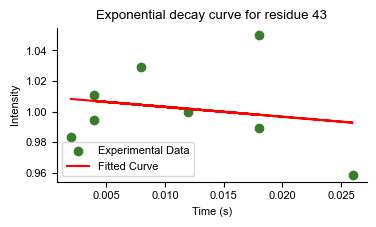

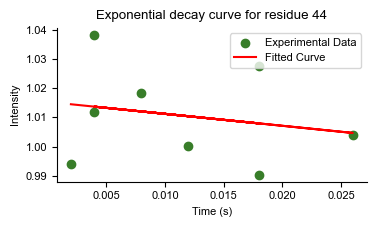

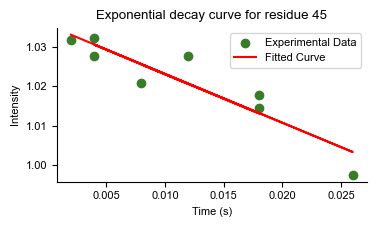

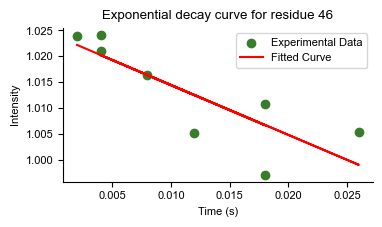

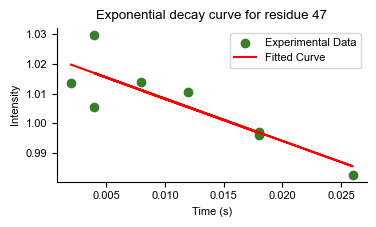

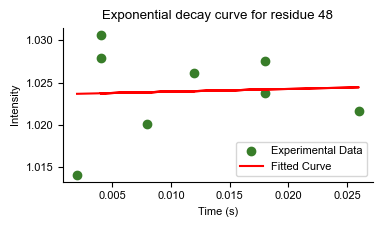

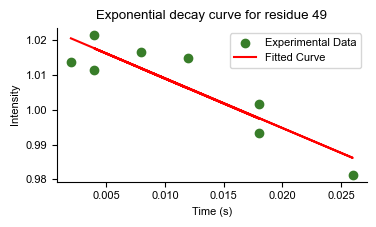

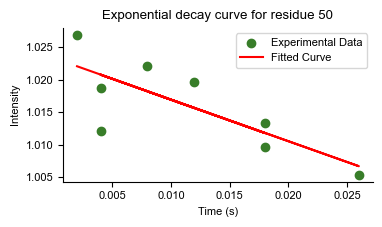

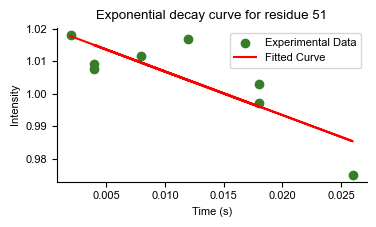

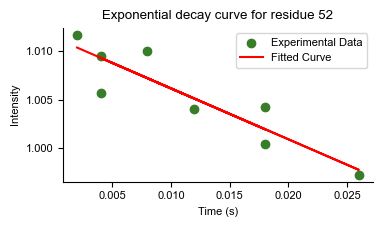

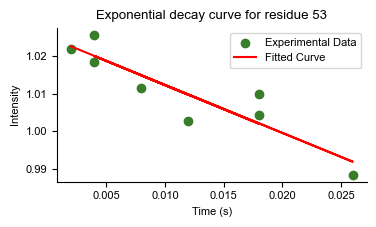

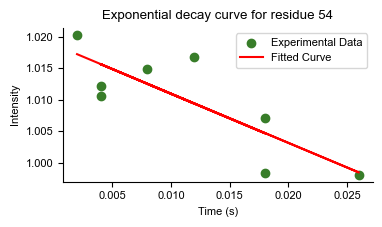

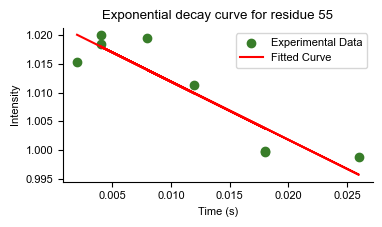

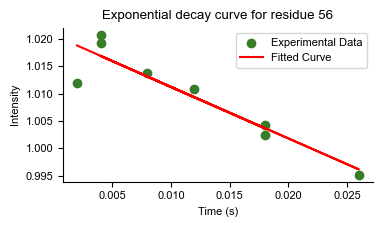

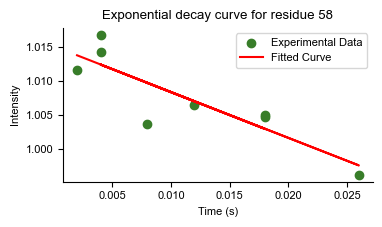

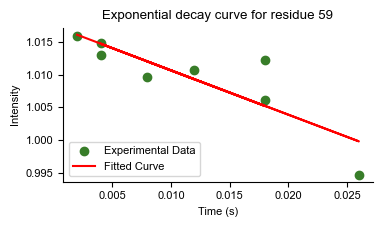

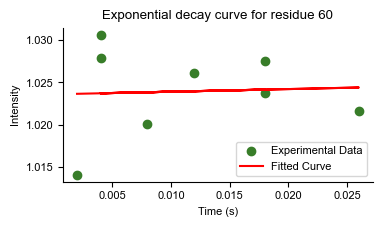

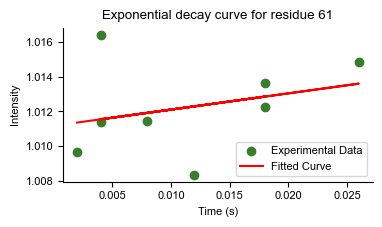

In [38]:
# Empty array to store 2 * R_{sigma,rho} for each residue 
r_sigma_rho = np.zeros(19)
error_r_sigma_rho = np.zeros(19)

# Loop through all the residues 
for i in range(19):
    residue_number = i + 43
    # Check if the data exists for this residue number
    if residue_number in four_rates_t:  
        x = four_rates_t[residue_number][0]
        y = combined_four_rates[i]

        # Create parameters with initial guesses
        r_sigma_rho_params = Parameters()
        r_sigma_rho_params.add('A', value=1.0)   # Initial guess for scaling factor 
        r_sigma_rho_params.add('rate', value=1.0) # Initial guess for rate 

        # Fit the model to the data
        r_sigma_rho_result = exponential_decay_model.fit(y, r_sigma_rho_params, x=x)

        # Save the rate value and its standard error to the arrays defined above 
        r_sigma_rho[i] = r_sigma_rho_result.params['rate'].value
        error_r_sigma_rho[i] = r_sigma_rho_result.params['rate'].stderr

        # Plot the exponential decay curves 
        plt.figure(figsize=(4, 2))
        plt.scatter(x, y, color=orf6_ctr_trans, label='Experimental Data')
        plt.plot(x, r_sigma_rho_result.best_fit, color='r', label='Fitted Curve')

        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        plt.xlabel('Time (s)')
        plt.ylabel('Intensity')
        plt.title(f'Exponential decay curve for residue {residue_number}')
        plt.legend()

# Print the residue number, rate and standard error 
for i in range(19):
    print(f"Residue {i+43}: rate = {r_sigma_rho[i]}, stderr = {error_r_sigma_rho[i]}")

<b> Now we need to calculate Rdd <b>

if you fit with A*exp(-r*t) then:
    This gives 2*R(sigma,rho)
    The equation is R(sigma,rho) = sin**2(thetaH)*sin**2(thetaN)*Rdd
    so Rdd = R(sigma,rho)/sin**2(thetaH)*sin**2(thetaN)
    Then divide by 2

else if fit with A*exp(-2*r*t) then:
    This gives R(sigma,rho)
    The equation is R(sigma,rho) = sin**2(thetaH)*sin**2(thetaN)*Rdd
    so Rdd = R(sigma,rho)/sin**2(thetaH)*sin**2(thetaN)
    DO NOT divide by 2

In [39]:
# Import chemical shift data and convert to a usable format 

CS_600 = pd.read_csv('orf6-ctr/relaxation_data/trans/600_rdd/1H-15N-shifts-600.list',delim_whitespace=True,dtype=float,header=None)
CS_array_600 = CS_600.to_numpy()
CS_N = CS_array_600[:,0]
CS_HN = CS_array_600[:,1]
# 21 residues, but missing rates for S41,K42 and P57 so make them 0
positions_CS = [14]
CS_N = np.insert(CS_N, positions_CS, 0)
CS_HN = np.insert(CS_HN, positions_CS, 0)

In [40]:
# Arrays to store the Rdd and other values required for calculation 
rdd = np.zeros(19) # previously saved in Rdd_600.txt
rdd_error = np.zeros(19) 
sin_theta_N = np.zeros(19)
sin_theta_HN = np.zeros(19)

# Loop from 0 to 18
for i in range(19):
    offsetN = CS_N[i]  
    offsetHN = CS_HN[i] 
    
    # Calculate sin_theta_H and sin_theta_N for the current i
    sin_theta_N[i] = CalcThetaN(offsetN)
    sin_theta_HN[i] = CalcThetaH(offsetHN)
    
    # Calculate Rdd and error for the current i (need to divide by 2)
    rdd[i] = 0.5 * (r_sigma_rho[i] / (sin_theta_HN[i] * sin_theta_N[i]))

    # Calculate the error in Rdd for the current i 
    rdd_error[i] = 0.5 * (error_r_sigma_rho[i] / (sin_theta_HN[i] * sin_theta_N[i]))

# add 0 to replace poorly fitted data (not included in the plot, but comment this out to see the Rdd rates)
poor_pos = [0, 1, 5, 17, 18]
rdd_clean = np.copy(rdd)
rdd_clean[poor_pos] = 0
rdd_error_clean = np.copy(rdd_error)
rdd_error_clean[poor_pos] = 0

# Remove index P57 for the calculation (create array without P57 as all other rates don't have proline)
rdd_no_P57 = np.delete(rdd_clean, 14)
rdd_error_no_P57 = np.delete(rdd_error_clean, 14)

<b> Spectral density mapping for 600 MHz data <b> 

Use the R1, R2, and NOE to calculate J(0), J(omegaN), J(OmegaH), 

In [41]:
# Calculate J0 and J0dd 

# make empty arrays to store all things 
sigma = np.zeros(18) # sigma NH - heteronuclear cross relaxation rate 
sigma_esd = np.zeros(18) # errror in sigma NH
d2J087 = np.zeros(18)  
r1p = np.zeros(18) #R1 prime
r2p = np.zeros(18) #R2 prime 
JwN = np.zeros(18) # spectral density omega N
J0 = np.zeros(18) # spectral density at 0 frequency
JwH = np.zeros(18) # spectral density omega H
J0dd = np.zeros(18) # spectral density at 0 frequency Rdd

for n in range(18):
    # Calculate sigma
    sigma[n] = (gamma_N15 / gamma_H1) * r1_trans_600[n,1] * (noe_trans_600[n,1] - 1)
    # Calculate sigma_esd
    # Error propagation --> sigmaAB = sqrt((A*sigmaB)**2 + (B*sigmaA)**2)          
    sigma_esd[n] = (gamma_N15 / gamma_H1) * np.sqrt(((noe_trans_600[n,1] - 1) * r1_trans_600[n,1])**2 + (r1_trans_600[n,1] * noe_trans_600[n,1])**2)
    d2J087[n] = 4.*sigma[n]/5.
    r1p[n] = r1_trans_600[n,1]-1.249*sigma[n] 
    r2p[n] = r2_trans_600[n]-1.079*sigma[n] 
    JwN[n] = r1p[n]/(c*c+3*d*d/4.)
    #Calculate J0 using R1 and NOE
    J0[n] = 0.25*(r2p[n]/(d*d/8.+c*c/6.)-3.*JwN[n])
    JwH[n] = d2J087[n]/(d*d)

    # Calculate J(0) from the Rdd rate:
    J0dd[n] = (rdd_no_P57[n]*8./(d*d) + 3.*JwN[n] - 0.845*JwH[n] ) /4.

In [42]:
# Define things for monte carlo simulation error analysis values

# Number of residues 
num_residues = 18

# Define the number of Monte Carlo samples 
num_MC = 100000 #this can be changed

In [43]:
# Monte carlo simulation to get the J0 and J0dd error 

# Create empty arrays 
r1_trans_600_MC = np.zeros((num_residues, num_MC))
r2_trans_600_MC = np.zeros((num_residues, num_MC))
noe_trans_600_MC = np.zeros((num_residues, num_MC))
rdd_trans_600_MC = np.zeros((num_residues, num_MC))
sigma_MC = np.zeros((num_residues, num_MC))
sigma_esd_MC = np.zeros((num_residues, num_MC))
d2J087_MC = np.zeros((num_residues, num_MC))
r1p_MC = np.zeros((num_residues, num_MC))
r2p_MC = np.zeros((num_residues, num_MC))
JwN_MC = np.zeros((num_residues, num_MC))
J0_MC = np.zeros((num_residues, num_MC))
JwH_MC = np.zeros((num_residues, num_MC))
J0dd_MC = np.zeros((num_residues, num_MC))

for i in range(num_residues): # loop through all residues    
    for j in range(num_MC): # monte carlo ting
        # Generate random samples using a normal distribution
        r1_trans_600_MC[i,j] = np.random.normal(r1_trans_600[i,1], r1_trans_600[i,2])
        r2_trans_600_MC[i,j] = np.random.normal(r2_trans_600[i], r2_trans_600_error[i])
        noe_trans_600_MC[i,j] = np.random.normal(noe_trans_600[i,1], noe_trans_600[i,2])
        rdd_trans_600_MC[i,j] = np.random.normal(rdd_no_P57[i], rdd_error_no_P57[i])
        
        sigma_MC[i,j] = (gamma_N15 / gamma_H1) * r1_trans_600_MC[i,j] * (noe_trans_600_MC[i,j] - 1)
        
        # Calculate sigma_esd
        # Error propagation --> sigmaAB = sqrt((A*sigmaB)**2 + (B*sigmaA)**2)
        sigma_esd_MC[i, j] = (gamma_N15 / gamma_H1) * np.sqrt(((noe_trans_600_MC[i,j] - 1) * r1_trans_600_MC[i,j])**2 + (r1_trans_600_MC[i,j] * noe_trans_600_MC[i,j])**2)
        d2J087_MC[i, j] = 4. * sigma_MC[i,j] / 5.
        r1p_MC[i, j] = r1_trans_600_MC[i,j] - 1.249 * sigma_MC[i,j]
        r2p_MC[i, j] = r2_trans_600_MC[i,j] - 1.079 * sigma_MC[i,j]
        JwN_MC[i, j] = r1p_MC[i, j] / (c * c + 3 * d * d / 4.)
        # Calculate J0 using r1 and NOE
        J0_MC[i, j] = 0.25 * (r2p_MC[i, j] / (d * d / 8. + c * c / 6.) - 3. * JwN_MC[i, j])
        JwH_MC[i, j] = d2J087_MC[i, j] / (d * d)
        # Calculate J(0) from the rdd rate:
        J0dd_MC[i, j] = (rdd_trans_600_MC[i,j] * 8. / (d * d) + 3. * JwN_MC[i, j] - 0.845 * JwH_MC[i, j]) / 4.

# Calculate the mean and standard deviation for each residue

mean_J0 = np.zeros(num_residues)
mean_J0dd = np.zeros(num_residues)
std_dev_J0 = np.zeros(num_residues)
std_dev_J0dd = np.zeros(num_residues)

for i in range(num_residues):
    mean_J0[i] = np.mean(J0_MC[i][:])
    mean_J0dd[i] = np.mean(J0dd_MC[i][:])
    std_dev_J0[i] = np.std(J0_MC[i][:])
    std_dev_J0dd[i] = np.std(J0dd_MC[i][:])

# Convert from seconds to ns 

#monte carlo values 
mean_J0_ns = mean_J0*1e9
mean_J0dd_ns = mean_J0dd*1e9
std_dev_J0_ns = std_dev_J0*1e9
std_dev_J0dd_ns = std_dev_J0dd*1e9

# exp values in nanoseconds
J0_ns = J0*1e9
J0dd_ns = J0dd*1e9

<b> Report directly on exchange <b> 
1. Take the J0_dd you have calculated
2. Re-calculate the R2 with J0_dd instead of J0
3. Take the difference of the measured R2 and the R2 re-calculated using the J0_dd
4. Call this Rex 

In [44]:
## Calculate R2_diff using J0dd - this reports on chemical exchange 

r2_dd = np.zeros(18)
r2_diff = np.zeros(18)

for i in range(18):
    r2_dd[i] = (4*J0dd[i] + 3*JwN[i]) * (d*d/8+c*c/6) #J0dd in seconds
    # calculate the difference between r2 and r2 calculated from the exchange free experiment 
    r2_diff[i] = r2_trans_600[i] - r2_dd[i] 

In [45]:
# Monte carlo simulation to get the error for the difference in R2 

J0dd_MC = np.zeros((num_residues, num_MC))
r2_600_MC = np.zeros((num_residues, num_MC))
r2_dd_MC = np.zeros((num_residues, num_MC))
r2_diff_MC = np.zeros((num_residues, num_MC))

for i in range(num_residues): # loop through all residues    
    for j in range(num_MC): # monte carlo ting
        # Generate random samples for using normal distribution
        J0dd_MC[i,j] = np.random.normal(J0dd[i], std_dev_J0dd[i])
        r2_600_MC[i,j] = np.random.normal(r2_trans_600[i], r2_trans_600_error[i])     

        r2_dd_MC[i, j] = (4 * J0dd_MC[i,j] + 3 * JwN[i]) * (d * d / 8 + c * c / 6)
        r2_diff_MC[i, j] = r2_600_MC[i,j] - r2_dd_MC[i,j]

# Get the mean and error for R2_diff from the MC simulation 
mean_r2_diff = np.zeros(num_residues)
std_dev_r2_diff = np.zeros(num_residues)

for i in range(num_residues):
    mean_r2_diff[i] = np.mean(r2_diff_MC[i][:])
    std_dev_r2_diff[i] = np.std(r2_diff_MC[i][:])

<b> Plot all relaxation data shown in the manuscript <b>

In [46]:
## Need to make arrays all the same length for plotting (this is long) 

# 21 residues, but missing rates for S41,K42 and P57 so make them 0 (in general) 
positions_relaxation = [0, 0, 14]
# for NOE 800 MHz K48 did not converge so use 
positions_k48_NOE_800MHz = [0,0,5,13]


### trans 600 MHz rates and errors 
# rates 
r1_trans_all_600 = np.insert(r1_trans_600[:,1], positions_relaxation, 0)
noe_trans_all_600 = np.insert(noe_trans_600[:,1], positions_relaxation, 0)
r2_trans_all_600 = np.insert(r2_trans_600, positions_relaxation, 0)
j0_trans_all_600 = np.insert(J0_ns, positions_relaxation, 0)
rdd_trans_all_600 = np.insert(rdd_no_P57, positions_relaxation, 0) 
r2_diff_trans_all_600 = np.insert(r2_diff, positions_relaxation, 0) 

#error
r1_trans_all_error_600 = np.insert(r1_trans_600[:,2], positions_relaxation, 0)
noe_trans_all_error_600 = np.insert(noe_trans_600[:,2], positions_relaxation, 0)
r2_trans_all_error_600 = np.insert(r2_trans_600_error, positions_relaxation, 0)
j0_trans_all_error_600 = np.insert(std_dev_J0_ns, positions_relaxation, 0)
rdd_trans_all_error_600 = np.insert(rdd_error_no_P57, positions_relaxation, 0)
r2_diff_trans_all_error_600 = np.insert(std_dev_r2_diff, positions_relaxation, 0)

# mask the 0's from the plot
masked_r1_trans_600 = ma.masked_equal(r1_trans_all_600, 0)
masked_noe_trans_600 = ma.masked_equal(noe_trans_all_600, 0)
masked_r2_trans_600 = ma.masked_equal(r2_trans_all_600, 0)
masked_j0_trans_600 = ma.masked_equal(j0_trans_all_600, 0)
masked_rdd_trans_600 = ma.masked_equal(rdd_trans_all_600, 0)

### trans 800 MHz rates and errors 
# for the rates
r1_trans_all_800 = np.insert(r1_trans_800[:,1], positions_relaxation, 0)
noe_trans_all_800 = np.insert(noe_trans_800[:,1], positions_k48_NOE_800MHz, 0)
r2_trans_all_800 = np.insert(r2_trans_800, positions_relaxation, 0)
# error 
r1_trans_all_error_800 = np.insert(r1_trans_800[:,2], positions_relaxation, 0)
noe_trans_all_error_800 = np.insert(noe_trans_800[:,2], positions_k48_NOE_800MHz, 0)
r2_trans_all_error_800 = np.insert(r2_trans_800_error, positions_relaxation, 0)
# mask the 0's from the plot
masked_r1_trans_800 = ma.masked_equal(r1_trans_all_800, 0)
masked_noe_trans_800 = ma.masked_equal(noe_trans_all_800, 0)
masked_r2_trans_800 = ma.masked_equal(r2_trans_all_800, 0)

### cis 

# Empty arrays of length 21 
r1_cis_all_600 = np.zeros(21)
r2_cis_all_600 = np.zeros(21)
r1_cis_error_all_600 = np.zeros(21)
r2_cis_error_all_600 = np.zeros(21)
r1_cis_all_800 = np.zeros(21)
r2_cis_all_800 = np.zeros(21)
r1_cis_error_all_800 = np.zeros(21)
r2_cis_error_all_800 = np.zeros(21)

r1_cis_all_600[15:16] = r1_cis_600[0:1,1]  # Insert the first value at index 15 (Q56)
r1_cis_all_600[18:19] = r1_cis_600[1:2,1]  # Insert the second value at index 18 (E59)
r2_cis_all_600[15:16] = r2_cis_600[0:1]  # Insert the first value at index 15
r2_cis_all_600[18:19] = r2_cis_600[1:2]  # Insert the second value at index 18
r1_cis_error_all_600[15:16] = r1_cis_600[0:1,2]  # Insert the first value at index 15
r1_cis_error_all_600[18:19] = r1_cis_600[1:2,2]  # Insert the second value at index 18
r2_cis_error_all_600[15:16] = r2_cis_600_error[0:1]  # Insert the first value at index 15
r2_cis_error_all_600[18:19] = r2_cis_600_error[1:2]  # Insert the second value at index 18
r1_cis_all_800[15:16] = r1_cis_800[0:1,1]  # Insert the first value at index 15 (Q56)
r1_cis_all_800[17:18] = r1_cis_800[1:2,1]  # Insert the second value at index 17 (M58)
r1_cis_all_800[18:19] = r1_cis_800[2:3,1]  # Insert the second value at index 18 (E59) 
r2_cis_all_800[15:16] = r2_cis_800[0:1]  # Insert the first value at index 15
r2_cis_all_800[17:18] = r2_cis_800[1:2]  # Insert the second value at index 17
r2_cis_all_800[18:19] = r2_cis_800[2:3]  # Insert the third value at index 18
r1_cis_error_all_800[15:16] = r1_cis_800[0:1,2]  # Insert the first value at index 15
r1_cis_error_all_800[17:18] = r1_cis_800[1:2,2]  # Insert the second value at index 17
r1_cis_error_all_800[18:19] = r1_cis_800[2:3,2]  # Insert the third value at index 18
r2_cis_error_all_800[15:16] = r2_cis_800_error[0:1]  # Insert the first value at index 15
r2_cis_error_all_800[17:18] = r2_cis_800_error[1:2]  # Insert the second value at index 17
r2_cis_error_all_800[18:19] = r2_cis_800_error[2:3]  # Insert the third value at index 18

# Remove 0's from the plots 
masked_r1_cis_600 = ma.masked_equal(r1_cis_all_600, 0)
masked_r2_cis_600 = ma.masked_equal(r2_cis_all_600, 0)
masked_r1_cis_800 = ma.masked_equal(r1_cis_all_800, 0)
masked_r2_cis_800 = ma.masked_equal(r2_cis_all_800, 0)

## For r2 diff - also want to remove the residues with a poor fit 
poor_fit = [1,2,3,7,19,20]
np.put(r2_diff_trans_all_600, poor_fit, 0)
np.put(r2_diff_trans_all_error_600, poor_fit, 0)
masked_r2_diff_600 = ma.masked_equal(r2_diff_trans_all_600, 0)
masked_errors_r2_diff_600  = ma.masked_equal(r2_diff_trans_all_600, 0)

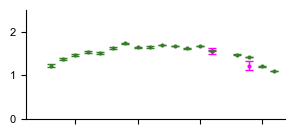

In [47]:
# Plot R1 600 MHz

fig, (ax1) = plt.subplots(1, 1)

ax1.errorbar(resid, masked_r1_cis_600, yerr=r1_cis_error_all_600, color=orf6_ctr_cis,
             marker='o', markersize=2, capsize=3, linestyle='None', label=r'$\mathit{cis}$',linewidth=1)
ax1.errorbar(resid, masked_r1_trans_600, yerr=r1_trans_all_error_600, color=orf6_ctr_trans,
             marker='o', markersize=2, capsize=3, linestyle='None', label=r'$\mathit{trans}$', linewidth=1)

#ax1.set_ylabel(r'$^{15}\mathrm{N}\ \mathit{R}_{1}\ (\mathrm{s}^{-1})$')
#ax1.set_xlabel(r'Residue number')
ax1.set_ylim(0,2.5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(min(resid), max(resid)+1, 1))
#ax1.legend()
#ax1.set_title('R1 at 14.1 T plot')

# Set the figure size in mm
plt.gcf().set_size_inches(85/ 25.4,36/25.4)

for ax in [ax1]:
    ax.set_xticks(relaxation_ticks)
    ax.set_xticklabels([])  
#ax1.set_xticklabels(relaxation_ticks)

#plt.savefig('figures/r1_600.pdf', format='pdf', dpi=2000,transparent=True,bbox_inches='tight')


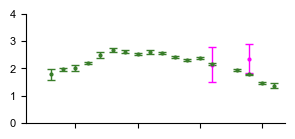

In [48]:
# Plot R2 600 MHz

fig, (ax1) = plt.subplots(1, 1)

ax1.errorbar(resid, masked_r2_cis_600, yerr=r2_cis_error_all_600, color=orf6_ctr_cis,
             marker='o', markersize=2, capsize=3, linestyle='None', label=r'$\mathit{cis}$',linewidth=1)
ax1.errorbar(resid, masked_r2_trans_600, yerr=r2_trans_all_error_600, color=orf6_ctr_trans,
             marker='o', markersize=2, capsize=3, linestyle='None', label=r'$\mathit{trans}$', linewidth=1)

#ax1.set_ylabel(r'$^{15}\mathrm{N}\ \mathit{R}_{2}\ (\mathrm{s}^{-1})$')
#ax1.set_xlabel(r'Residue number')
ax1.set_ylim(0,4)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(min(resid), max(resid)+1, 1))
#ax1.legend()
#ax1.set_title('R2 at 14.1 T plot')

# Set the figure size in mm
plt.gcf().set_size_inches(85/ 25.4,36/25.4)

for ax in [ax1]:
    ax.set_xticks(relaxation_ticks)
    ax.set_xticklabels([])  
#ax1.set_xticklabels(relaxation_ticks)

#plt.savefig('figures/r2_600.pdf', format='pdf', dpi=2000,transparent=True,bbox_inches='tight')


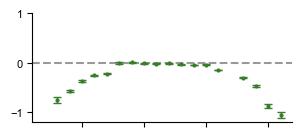

In [49]:
# Plot NOE 600 MHz 

fig, (ax1) = plt.subplots(1, 1)

ax1.errorbar(resid, masked_noe_trans_600, yerr=noe_trans_all_error_600, color=orf6_ctr_trans,
             marker='o', markersize=2, capsize=3, linestyle='None', label=r'$\mathit{trans}$', linewidth=1)

#ax1.set_ylabel(r'$^1\mathrm{H}-^{15}\mathrm{N}-\mathrm{NOE}$')
#ax1.set_xlabel(r'Residue number')
ax1.set_ylim(-1.2,1)
ax1.axhline(y=0, color='black', linestyle='--',alpha=0.4,zorder=-1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(min(resid), max(resid)+1, 1))
#ax1.legend()
#ax1.set_title('NOE at 14.1 T plot')

# Set the figure size in mm
plt.gcf().set_size_inches(85/ 25.4,36/25.4)

for ax in [ax1]:
    ax.set_xticks(relaxation_ticks)
    ax.set_xticklabels([])  
#ax1.set_xticklabels(relaxation_ticks)

#plt.savefig('figures/noe_600.pdf', format='pdf', dpi=2000,transparent=True,bbox_inches='tight')


[Text(45, 0, '45'), Text(50, 0, '50'), Text(55, 0, '55'), Text(60, 0, '60')]

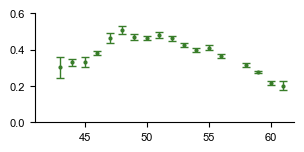

In [50]:
# Plot J0 (ns) 600 MHz

fig, (ax1) = plt.subplots(1, 1)

ax1.errorbar(resid, masked_j0_trans_600, yerr=j0_trans_all_error_600, color=orf6_ctr_trans,
             marker='o', markersize=2, capsize=3, linestyle='None', label=r'$\mathit{trans}$', linewidth=1)

#ax1.set_ylabel('J(0) (ns)')
#ax1.set_xlabel(r'Residue number')
ax1.set_ylim(0,0.6)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(min(resid), max(resid)+1, 1))
#ax1.legend()
#ax1.set_title('J0 at 14.1 T plot')

plt.gcf().set_size_inches(85/ 25.4,36/25.4)

for ax in [ax1]:
    ax.set_xticks(relaxation_ticks)
    ax.set_xticklabels([])  
ax1.set_xticklabels(relaxation_ticks)

#plt.savefig('figures/j0_600.pdf', format='pdf', dpi=2000,transparent=True,bbox_inches='tight')


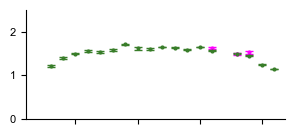

In [51]:
# Plot R1 800 MHz

fig, (ax1) = plt.subplots(1, 1)

ax1.errorbar(resid, masked_r1_cis_800, yerr=r1_cis_error_all_800, color=orf6_ctr_cis,
             marker='o', markersize=2, capsize=3, linestyle='None', label=r'$\mathit{cis}$',linewidth=1)
ax1.errorbar(resid, masked_r1_trans_800, yerr=r1_trans_all_error_800, color=orf6_ctr_trans,
             marker='o', markersize=2, capsize=3, linestyle='None', label=r'$\mathit{trans}$', linewidth=1)

#ax1.set_ylabel(r'$^{15}\mathrm{N}\ \mathit{R}_{1}\ (\mathrm{s}^{-1})$')
#ax1.set_xlabel(r'Residue number')
ax1.set_ylim(0,2.5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(min(resid), max(resid)+1, 1))
#ax1.legend()
#ax1.set_title('R1 at 18.8 T plot')

plt.gcf().set_size_inches(85/ 25.4,36/25.4)

for ax in [ax1]:
    ax.set_xticks(relaxation_ticks)
    ax.set_xticklabels([])  
#ax1.set_xticklabels(relaxation_ticks)

#plt.savefig('figures/r1_800.pdf', format='pdf', dpi=2000,transparent=True,bbox_inches='tight')


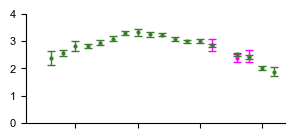

In [52]:
# Plot R2 800 MHz

fig, (ax1) = plt.subplots(1, 1)

ax1.errorbar(resid, masked_r2_cis_800, yerr=r2_cis_error_all_800, color=orf6_ctr_cis,
             marker='o', markersize=2, capsize=3, linestyle='None', label=r'$\mathit{cis}$',linewidth=1)
ax1.errorbar(resid, masked_r2_trans_800, yerr=r2_trans_all_error_800, color=orf6_ctr_trans,
             marker='o', markersize=2, capsize=3, linestyle='None', label=r'$\mathit{trans}$', linewidth=1)

#ax1.set_ylabel(r'$^{15}\mathrm{N}\ \mathit{R}_{2}\ (\mathrm{s}^{-1})$')
#ax1.set_xlabel(r'Residue number')
ax1.set_ylim(0,4)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(min(resid), max(resid)+1, 1))
#ax1.legend()
#ax1.set_title('R2 at 18.8 T plot')

plt.gcf().set_size_inches(85/ 25.4,36/25.4)

for ax in [ax1]:
    ax.set_xticks(relaxation_ticks)
    ax.set_xticklabels([])  
#ax1.set_xticklabels(relaxation_ticks)

#plt.savefig('figures/r2_800.pdf', format='pdf', dpi=2000,transparent=True,bbox_inches='tight')


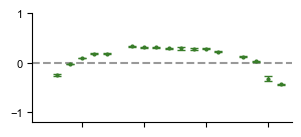

In [53]:
# Plot NOE 800 MHz 

fig, (ax1) = plt.subplots(1, 1)

ax1.errorbar(resid, masked_noe_trans_800, yerr=noe_trans_all_error_800, color=orf6_ctr_trans,
             marker='o', markersize=2, capsize=3, linestyle='None', label=r'$\mathit{trans}$', linewidth=1)

#ax1.set_ylabel(r'$^1\mathrm{H}-^{15}\mathrm{N}-\mathrm{NOE}$')
#ax1.set_xlabel(r'Residue number')
ax1.set_ylim(-1.2,1)
ax1.axhline(y=0, color='black', linestyle='--',alpha=0.4,zorder=-1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(min(resid), max(resid)+1, 1))
#ax1.legend()
#ax1.set_title('NOE at 18.8 T plot')
plt.gcf().set_size_inches(85/ 25.4,36/25.4)

for ax in [ax1]:
    ax.set_xticks(relaxation_ticks)
    ax.set_xticklabels([])  
#ax1.set_xticklabels(relaxation_ticks)

#plt.savefig('figures/noe_800.pdf', format='pdf', dpi=2000,transparent=True,bbox_inches='tight')


[Text(45, 0, '45'), Text(50, 0, '50'), Text(55, 0, '55'), Text(60, 0, '60')]

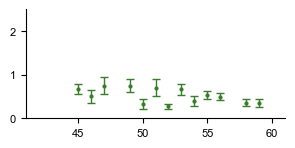

In [54]:
# Plot Rdd 600 MHz 

fig, (ax1) = plt.subplots(1, 1)

ax1.errorbar(resid, masked_rdd_trans_600, yerr=rdd_trans_all_error_600, color=orf6_ctr_trans,
             marker='o', markersize=2, capsize=3,label=r'$\mathit{cis}$',linewidth=1,linestyle='None')

#ax1.set_ylabel(r'$^{15}\mathrm{N}\ \mathit{R}_{dd}\ (\mathrm{s}^{-1})$')
#ax1.set_xlabel(r'Residue number')
ax1.set_ylim(0,2.5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(min(resid), max(resid)+1, 1))

#ax1.set_title('Rdd plot AT 14.1 T')
plt.gcf().set_size_inches(85/ 25.4,36/25.4)

for ax in [ax1]:
    ax.set_xticks(relaxation_ticks)
    ax.set_xticklabels([]) 
ax1.set_xticklabels(relaxation_ticks)

#plt.savefig('figures/rdd_600.pdf', format='pdf', dpi=2000,transparent=True,bbox_inches='tight')


[Text(45, 0, '45'), Text(50, 0, '50'), Text(55, 0, '55'), Text(60, 0, '60')]

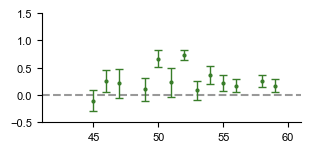

In [55]:
# Plot R_exchange (zoom-in)

fig, (ax1) = plt.subplots(1, 1)

ax1.errorbar(resid, masked_r2_diff_600, yerr=r2_diff_trans_all_error_600, color=orf6_ctr_trans,
             marker='o', markersize=2, capsize=3, linestyle='None', label=r'$\mathit{trans}$', linewidth=1)

#ax1.set_ylabel(r'$\mathrm{R}_{ex}\,  (\mathrm{s}^{-1})$')
ax1.set_ylim(-0.5,1.5) # zoom-in
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(min(resid), max(resid)+1, 1))
ax1.axhline(y=0, color='black', linestyle='--',alpha=0.4,zorder=-1)
plt.gcf().set_size_inches(85/ 25.4,36/25.4)
#ax1.set_title('Rex plot AT 14.1 T')

for ax in [ax1]:
    ax.set_xticks(relaxation_ticks)
    ax.set_xticklabels([])  
ax1.set_xticklabels(relaxation_ticks)

#plt.savefig('figures/rex_zoomIN.pdf', format='pdf', dpi=2000,transparent=True,bbox_inches='tight')


[Text(45, 0, '45'), Text(50, 0, '50'), Text(55, 0, '55'), Text(60, 0, '60')]

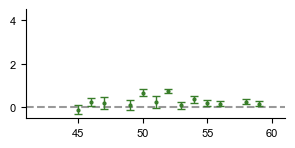

In [56]:
# Plot R_exchange (zoom-out)

fig, (ax1) = plt.subplots(1, 1)

ax1.errorbar(resid, masked_r2_diff_600, yerr=r2_diff_trans_all_error_600, color=orf6_ctr_trans,
             marker='o', markersize=2, capsize=3, linestyle='None', label=r'$\mathit{trans}$', linewidth=1)

#ax1.set_ylabel(r'$\mathrm{R}_{ex}\,  (\mathrm{s}^{-1})$')
ax1.set_ylim(-0.5,4.5) # zoom-in
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(min(resid), max(resid)+1, 1))
ax1.axhline(y=0, color='black', linestyle='--',alpha=0.4,zorder=-1)
plt.gcf().set_size_inches(85/ 25.4,36/25.4)
#ax1.set_title('Rex plot AT 14.1 T')

for ax in [ax1]:
    ax.set_xticks(relaxation_ticks)
    ax.set_xticklabels([])  
ax1.set_xticklabels(relaxation_ticks)

#plt.savefig('figures/rex_zoomOUT.pdf', format='pdf', dpi=2000,transparent=True,bbox_inches='tight')


## 15N-DOSY-HSQC data analysis at 288 K

The DOSY subdirectory contains FuDA input files. The intensities of peaks were quantified by lineshape-fitting with the software package FuDA and labelled as *.out, with `c` indicating cis-P57 peaks (3). 

The 8 (.out) files for E55, Q56, M58, and E59 cis-P57 and trans-P57 peaks are used in the analysis below. 

In [57]:
# Upload data 
e55t = pd.read_csv('orf6-ctr/dosy/E55N-HN.out',delim_whitespace=True,dtype=float,header=18)
e55c = pd.read_csv('orf6-ctr/dosy/E55cN-HN.out',delim_whitespace=True,dtype=float,header=18)

q56t = pd.read_csv('orf6-ctr/dosy/Q56N-HN.out',delim_whitespace=True,dtype=float,header=18)
q56c = pd.read_csv('orf6-ctr/dosy/Q56cN-HN.out',delim_whitespace=True,dtype=float,header=18)

m58t = pd.read_csv('orf6-ctr/dosy/M58N-HN.out',delim_whitespace=True,dtype=float,header=18)
m58c = pd.read_csv('orf6-ctr/dosy/M58cN-HN.out',delim_whitespace=True,dtype=float,header=18)

e59t = pd.read_csv('orf6-ctr/dosy/E59N-HN.out',delim_whitespace=True,dtype=float,header=18)
e59c = pd.read_csv('orf6-ctr/dosy/E59cN-HN.out',delim_whitespace=True,dtype=float,header=18)

In [58]:
# convert to numpy array 
e55t_array = e55t.to_numpy()
e55c_array = e55c.to_numpy()
q56t_array = q56t.to_numpy()
q56c_array = q56c.to_numpy()
m58t_array = m58t.to_numpy()
m58c_array = m58c.to_numpy()
e59t_array = e59t.to_numpy()
e59c_array = e59c.to_numpy()

In [59]:
# exclude nan stuff 
e55t_array = e55t_array[:,0:3]
e55c_array = e55c_array[:,0:3]
q56t_array = q56t_array[:,0:3]
q56c_array = q56c_array[:,0:3]
m58t_array = m58t_array[:,0:3]
m58c_array = m58c_array[:,0:3]
e59t_array = e59t_array[:,0:3]
e59c_array = e59c_array[:,0:3]

In [60]:
#  Gradients (with detailed explanation to keep track of units) 

## this is in G/cm - 53.5 G/cm is the max grad strength (in difflist shown as 5.35 G/mm)
#Difframp (bottom of file) contains the list of actual powers used
#gpnam6 is the gradient pulse shape that is used for the stimulated echo
#which has a shape integral factor of 0.9. Difflist switches to G/cm from G/mm in Difframp.
OG = e55t_array[:,0] 
## I am converting G into G/m (almost SI units)
G_almost = OG *100. 
# I am now converting G into T/m (SI units), which will be used in the Stejskal–Tanner equation
G = G_almost/10000. 

In [61]:
# Normalise to I_0
int_e55_t = (e55t_array[:,1]/e55t_array[:,1].max())
int_e55_c = (e55c_array[:,1]/e55c_array[:,1].max()) 
int_q56_t = (q56t_array[:,1]/q56t_array[:,1].max()) 
int_q56_c = (q56c_array[:,1]/q56c_array[:,1].max())
int_m58_t = (m58t_array[:,1]/m58t_array[:,1].max()) 
int_m58_c = (m58c_array[:,1]/m58c_array[:,1].max())
int_e59_t = (e59t_array[:,1]/e59t_array[:,1].max()) 
int_e59_c = (e59c_array[:,1]/e59c_array[:,1].max())

In [62]:
# Normalise error to I_0
int_err_e55_t = (e55t_array[:,2]/e55t_array[:,1].max())
int_err_e55_c = (e55c_array[:,2]/e55c_array[:,1].max()) 
int_err_q56_t = (q56t_array[:,2]/q56t_array[:,1].max()) 
int_err_q56_c = (q56c_array[:,2]/q56c_array[:,1].max())
int_err_m58_t = (m58t_array[:,2]/m58t_array[:,1].max()) 
int_err_m58_c = (m58c_array[:,2]/m58c_array[:,1].max())
int_err_e59_t = (e59t_array[:,2]/e59t_array[:,1].max()) 
int_err_e59_c = (e59c_array[:,2]/e59c_array[:,1].max())

In [63]:
# plot for all cis and trans (including e55, but excluding because the errors are huge for cis) 
fit_e55_c, D_e55_c, D_err_e55_t = fit_DOSY_data(G, int_e55_c)
fit_e55_t, D_e55_t, D_err_e55_c = fit_DOSY_data(G, int_e55_t)
fit_q56_c, D_q56_c, D_err_q56_t = fit_DOSY_data(G, int_q56_c)
fit_q56_t, D_q56_t, D_err_q56_c = fit_DOSY_data(G, int_q56_t)
fit_m58_c, D_m58_c, D_err_m58_t = fit_DOSY_data(G, int_m58_c)
fit_m58_t, D_m58_t, D_err_m58_c = fit_DOSY_data(G, int_m58_t)
fit_e59_c, D_e59_c, D_err_e59_t = fit_DOSY_data(G, int_e59_c)
fit_e59_t, D_e59_t, D_err_e59_c = fit_DOSY_data(G, int_e59_t)

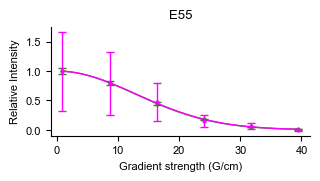

In [64]:
# Plot DOSY intensities for cis and trans (E55) 

fig, (ax1) = plt.subplots(1, 1)

### For plotting - back to G/cm (G*100)

ax1.errorbar(G*100, int_e55_t, yerr=int_err_e55_t,color=orf6_ctr_trans,
             marker='o', markersize=2, capsize=3, linestyle='None', linewidth=1, label='trans data')

ax1.errorbar(G*100, int_e55_c, yerr=int_err_e55_c, color=orf6_ctr_cis,
             marker='o', markersize=2, capsize=3, linestyle='None', linewidth=1, label='cis data')

# Plotting smoothed fitted curves
smooth_grads = np.linspace(np.min(G), np.max(G), 101, endpoint=True)
smooth_fit_e55_t = dosy(smooth_grads, Diff=D_e55_t)
smooth_fit_e55_c = dosy(smooth_grads, Diff=D_e55_c)

plt.plot(smooth_grads * 100, smooth_fit_e55_t, color=orf6_ctr_trans, linewidth=1, label='trans fit')
plt.plot(smooth_grads * 100, smooth_fit_e55_c, color=orf6_ctr_cis, linewidth=1, label='cis fit')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel('Gradient strength (G/cm)')
ax1.set_ylabel('Relative Intensity')

# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=8)
plt.title('E55')

# Set the figure size in mm
plt.gcf().set_size_inches(85/ 25.4,36/25.4)

# Show the plot
plt.show()

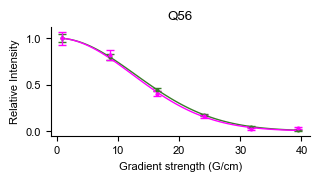

In [65]:
# Plot DOSY intensities for cis and trans (q56) 

fig, (ax1) = plt.subplots(1, 1)

### For plotting - back to G/cm (G*100)

ax1.errorbar(G*100, int_q56_t, yerr=int_err_q56_t,color=orf6_ctr_trans,
             marker='o', markersize=2, capsize=3, linestyle='None', linewidth=1, label='trans data')

ax1.errorbar(G*100, int_q56_c, yerr=int_err_q56_c, color=orf6_ctr_cis,
             marker='o', markersize=2, capsize=3, linestyle='None', linewidth=1, label='cis data')

# Plotting smoothed fitted curves
smooth_grads = np.linspace(np.min(G), np.max(G), 101, endpoint=True)
smooth_fit_q56_t = dosy(smooth_grads, Diff=D_q56_t)
smooth_fit_q56_c = dosy(smooth_grads, Diff=D_q56_c)

plt.plot(smooth_grads * 100, smooth_fit_q56_t, color=orf6_ctr_trans, linewidth=1, label='trans fit')
plt.plot(smooth_grads * 100, smooth_fit_q56_c, color=orf6_ctr_cis, linewidth=1, label='cis fit')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel('Gradient strength (G/cm)')
ax1.set_ylabel('Relative Intensity')

# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=8)
plt.title('Q56')

# Set the figure size in mm
plt.gcf().set_size_inches(85/ 25.4,36/25.4)

# Show the plot
plt.show()

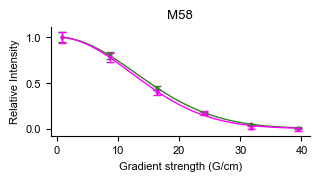

In [66]:
# Plot DOSY intensities for cis and trans (M58) 

fig, (ax1) = plt.subplots(1, 1)

### For plotting - back to G/cm (G*100)

ax1.errorbar(G*100, int_m58_t, yerr=int_err_m58_t,color=orf6_ctr_trans,
             marker='o', markersize=2, capsize=3, linestyle='None', linewidth=1, label='trans data')

ax1.errorbar(G*100, int_m58_c, yerr=int_err_m58_c, color=orf6_ctr_cis,
             marker='o', markersize=2, capsize=3, linestyle='None', linewidth=1, label='cis data')

# Plotting smoothed fitted curves
smooth_grads = np.linspace(np.min(G), np.max(G), 101, endpoint=True)
smooth_fit_m58_t = dosy(smooth_grads, Diff=D_m58_t)
smooth_fit_m58_c = dosy(smooth_grads, Diff=D_m58_c)

plt.plot(smooth_grads * 100, smooth_fit_m58_t, color=orf6_ctr_trans, linewidth=1, label='trans fit')
plt.plot(smooth_grads * 100, smooth_fit_m58_c, color=orf6_ctr_cis, linewidth=1, label='cis fit')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel('Gradient strength (G/cm)')
ax1.set_ylabel('Relative Intensity')

# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=8)
plt.title('M58')

# Set the figure size in mm
plt.gcf().set_size_inches(85/ 25.4,36/25.4)

# Show the plot
plt.show()

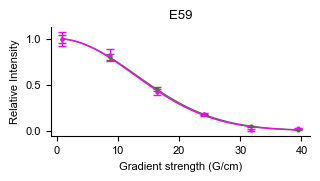

In [67]:
# Plot DOSY intensities for cis and trans (E59) 

fig, (ax1) = plt.subplots(1, 1)

### For plotting - back to G/cm (G*100)

ax1.errorbar(G*100, int_e59_t, yerr=int_err_e59_t,color=orf6_ctr_trans,
             marker='o', markersize=2, capsize=3, linestyle='None', linewidth=1, label='trans data')

ax1.errorbar(G*100, int_e59_c, yerr=int_err_e59_c, color=orf6_ctr_cis,
             marker='o', markersize=2, capsize=3, linestyle='None', linewidth=1, label='cis data')

# Plotting smoothed fitted curves
smooth_grads = np.linspace(np.min(G), np.max(G), 101, endpoint=True)
smooth_fit_e59_t = dosy(smooth_grads, Diff=D_e59_t)
smooth_fit_e59_c = dosy(smooth_grads, Diff=D_e59_c)

plt.plot(smooth_grads * 100, smooth_fit_e59_t, color=orf6_ctr_trans, linewidth=1, label='trans fit')
plt.plot(smooth_grads * 100, smooth_fit_e59_c, color=orf6_ctr_cis, linewidth=1, label='cis fit')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel('Gradient strength (G/cm)')
ax1.set_ylabel('Relative Intensity')

# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=8)
plt.title('E59')

# Set the figure size in mm
plt.gcf().set_size_inches(85/ 25.4,36/25.4)

# Show the plot
plt.show()

<b> Calculate the average diffusion coefficient for cis-P57 and trans-P57 conformations <b> 

In [68]:
# Take the mean and standard deviation for Q56, M58 and E59 
cis_D = np.asarray([D_q56_c, D_m58_c, D_e59_c])
trans_D = np.asarray([D_q56_t, D_m58_t, D_e59_t])

# calc mean and std for cis 
np.mean(cis_D), np.std(cis_D, ddof=1)

# calc mean and std for trans 
np.mean(trans_D), np.std(trans_D, ddof=1)

# store values 
cis_diffC = np.mean(cis_D)
trans_diffC = np.mean(trans_D)
cis_diffC_std = np.std(cis_D, ddof=1)
trans_diffC_std = np.std(trans_D, ddof=1)

print("Mean cis diffusion coefficient:", cis_diffC)
print("Mean trans diffusion coefficient:", trans_diffC)

Mean cis diffusion coefficient: 2.518703071085418e-10
Mean trans diffusion coefficient: 2.3424400427018973e-10


In [69]:
# Below is bootstrapping to obtain the error for cis-P57 and trans-P57 diffusion coefficients 
#Set the number of bootstrap samples
num_samples = 1000 #can change this 

In [70]:
# cis-P57 data 

random_samples_q56_c = np.random.normal(fit_q56_c, int_err_q56_c, size=(num_samples, len(fit_q56_c)))
random_samples_m58_c = np.random.normal(fit_m58_c, int_err_m58_c, size=(num_samples, len(fit_m58_c)))
random_samples_e59_c = np.random.normal(fit_e59_c, int_err_e59_c, size=(num_samples, len(fit_e59_c)))

# Store bootstrap results 
bootstrap_means = np.zeros((num_samples))

# Perform bootstrapping for each data
for i in range(num_samples):
    # Fit the model for each set of bootstrapped data
    out_q56_c = fit_DOSY_data(G, random_samples_q56_c[i])
    out_m58_c = fit_DOSY_data(G, random_samples_m58_c[i])
    out_e59_c = fit_DOSY_data(G, random_samples_e59_c[i])
    
    # Calculate the mean for each set of bootstrapped data
    mean_data = np.mean([out_q56_c[1], out_m58_c[1], out_e59_c[1]])
    
    # Store the mean for each bootstrap iteration
    bootstrap_means[i] = mean_data

# Calculate mean and standard deviation for the means
cis_diffC_bootstrap = np.mean(bootstrap_means)
cis_diffC_std_bootstrap = np.std(bootstrap_means)

print("Mean and Standard Deviation for combined q56_c, m58_c, e59_c:", cis_diffC_bootstrap, cis_diffC_std_bootstrap)

Mean and Standard Deviation for combined q56_c, m58_c, e59_c: 2.529292524550633e-10 8.953303621312867e-12


In [71]:
# trans-P57 data 

random_samples_q56_t = np.random.normal(fit_q56_t, int_err_q56_t, size=(num_samples, len(fit_q56_t)))
random_samples_m58_t = np.random.normal(fit_m58_t, int_err_m58_t, size=(num_samples, len(fit_m58_t)))
random_samples_e59_t = np.random.normal(fit_e59_t, int_err_e59_t, size=(num_samples, len(fit_e59_t)))

# Store bootstrap results 
bootstrap_means = np.zeros((num_samples,))

# Perform bootstrapping for each data
for i in range(num_samples):
    # Fit the model for each set of bootstrapped data
    out_q56_t = fit_DOSY_data(G, random_samples_q56_t[i])
    out_m58_t = fit_DOSY_data(G, random_samples_m58_t[i])
    out_e59_t = fit_DOSY_data(G, random_samples_e59_t[i])
    
    # Calculate the mean for each set of bootstrapped data
    mean_data = np.mean([out_q56_t[1], out_m58_t[1], out_e59_t[1]])
    
    # Store the mean for each bootstrap iteration
    bootstrap_means[i] = mean_data

# Calculate mean and standard deviation for the means
trans_diffC_bootstrap = np.mean(bootstrap_means)
trans_diffC_std_bootstrap = np.std(bootstrap_means)

print("Mean and Standard Deviation for combined q56_t, m58_t, e59_t:", trans_diffC_bootstrap, trans_diffC_std_bootstrap)

Mean and Standard Deviation for combined q56_t, m58_t, e59_t: 2.3462627757309315e-10 5.225658374766884e-12


<b> Determine the statistical significance of cis diffusion coefficient being larger than the trans diffusion coefficient <b>

From sample means i know cis (A) > trans (B) 

hypotheses:

H0: A <= B 

H1: A > B 

In [72]:
# Perform t-test 
t_stat, p_value = ttest_ind(cis_D, trans_D, equal_var=False, alternative='greater') # cannot assume equal variance, Welch's t-test

# Output results
print("t-statistic:", t_stat)
print("p-value:", p_value)

# Check significance
alpha = 0.05  # Significance level
if p_value < alpha:
    print("The difference between cis_diffC and trans_diffC is statistically significant (reject H0).")
else:
    print("There is no significant difference between cis_diffC and trans_diffC (cannot reject H0).")

t-statistic: 3.1793678172069124
p-value: 0.041954740996347085
The difference between cis_diffC and trans_diffC is statistically significant (reject H0).


In [73]:
# Degrees of freedom
df = len(cis_D) + len(trans_D) - 2 # -2 because 2 averages
print(df)

4


In [74]:
# Calculate probability
prob = t.cdf(t_stat, df)

print("Probability associated with t-value:", prob*100, '%')

Probability associated with t-value: 98.32222540826902 %


In [75]:
# Determine ratio
print('Diffusion coefficient ratio:', (trans_diffC/cis_diffC)*100, '%')
print('Trans state diffuses', 100 - (trans_diffC/cis_diffC)*100, '% more slowly than cis')

Diffusion coefficient ratio: 93.00183374503285 %
Trans state diffuses 6.9981662549671455 % more slowly than cis


## The End!! 